In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from statistics import mean
from torch.nn import MSELoss, L1Loss, SmoothL1Loss

import tensorflow.keras.datasets.mnist as MNIST

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
import warnings

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers, losses, optimizers
#from tensorflow.keras.models import Model, load_model
#from tensorflow.keras.utils import plot_model, to_categorical
#from keras.callbacks import EarlyStopping,ModelCheckpoint

#importing neural networks
import torch.nn as nn
import torch.nn.functional as func

#import packages
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import Conv1D
#from keras.layers import MaxPooling1D
#from keras.layers import Dropout, Flatten, BatchNormalization
#import keras.backend as kb

from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt 
import numpy as np
import os
import h5py
import random as rn
import cmath as cm
from statistics import mean
from matplotlib import rcParams

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

#import tensorflow.keras.datasets.mnist as MNIST

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings

import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
from matplotlib import rcParams

import os

# for dirname, _, filenames in os.walk('../DL-FPC/Data for DL-FPC'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# cwd=os.getcwd()

from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt 
import h5py
import random as rn
import cmath as cm
from scipy.io import savemat, loadmat
import nitime.timeseries as nts
import time

# Loading simulated dataset

In [2]:
# Load Simulated FIDs, which were simulated using FID-A
arrays = {}
f = h5py.File('../../Data for DL-FPC/TrainingData.mat','r')#need to add 'r' mode here to avoid warning
for k, v in f.items():
    arrays[k] = np.array(v)
FidsOFFtemp = np.transpose(arrays['OFF_fids']) 
FidsONtemp = np.transpose(arrays['ON_fids'])

FidsOFF = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
FidsON = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)
for pp in range(len(FidsOFF[:,0])):
    for kk in range(len(FidsOFF[0,:])):
        FidsOFF[pp,kk] = FidsOFFtemp[pp,kk][0] + 1j * FidsOFFtemp[pp,kk][1] 
        FidsON[pp,kk] = FidsONtemp[pp,kk][0] + 1j * FidsONtemp[pp,kk][1]
     
# Concatenate OFF and ON data - Training is performed using both OFF and ON
Fids = np.concatenate((FidsOFF, FidsON), axis=1)     

# Define Offsets - Randomize 
Phs = np.arange(-90, 90.001, (180/(len(Fids[0])-1)))
F0 = np.arange(-20, 20.0000001, (40/(len(Fids[0])-1))) 

rn.shuffle(Phs) #Randomize
rn.shuffle(F0) #Randomize

In [3]:
# defining line broadening function and parameters
lb_parameter = np.arange(0, 0.0200001, (0.02/(len(Fids[0])-1)))
rn.shuffle(lb_parameter)

time = np.arange(2048)/2000

def line_broadening(ts,width):
    n_dims=len(ts.shape)
    win=np.exp(-width*ts.time/np.float(ts.time._conversion_factor))
    new_data=ts.data*win
    
    return nts.TimeSeries(new_data, sampling_rate=ts.sampling_rate)

In [4]:
# JG: Fids and Spec for the Unaligned data
FidsUnAligned = np.empty((len(Fids[:,0]), len(Fids[0,:])), dtype = np.complex_)
FidsUnAlignedPhase = np.empty((len(Fids[:,0]), len(Fids[0,:])), dtype = np.complex_)
spectUnAligned = np.empty((len(Fids[:,0]), len(Fids[0,:])), dtype = np.complex_)
spectUnAlignedPhase = np.empty((len(Fids[:,0]), len(Fids[0,:])), dtype = np.complex_)

# JG: Spec for the Original data
# Is this used as ground truth?
spectAligned = np.empty((len(Fids[:,0]), len(Fids[0,:])), dtype = np.complex_)
spectAlignedPhase = np.empty((len(Fids[:,0]), len(Fids[0,:])), dtype = np.complex_)

In [5]:
# applying line broadening to samples
for kk in range(len(Fids[0,:])):
    # get the single FID
    Fids_kk = Fids[:,kk]
    
    if 18000 <= kk <= 20000 or 38000 <= kk <=  40000:
        #print('Fids_kk_lb')
        # get the single FID with LB
        arr=Fids_kk*np.exp(1j*np.pi)*(-1) #cool
        ts=nts.TimeSeries(data=arr, sampling_rate=1)
        width=lb_parameter[kk] 
    
        Fids_kk_lb=line_broadening(ts, width)
    else:
        #print('Fids_kk')
        Fids_kk_lb=Fids_kk
    
    # get the phase and freq offsets
    phasePart = np.exp(-1j * Phs[kk] * cm.pi / 180)
    freqPart = np.exp(-1j * time * F0[kk] * 2 * cm.pi)
    correction = np.multiply(freqPart,phasePart)
    
    # apply the phase and freq offsets on the FID after LB
    FidsUnAligned[:,kk] = np.multiply(Fids_kk_lb, correction) #[2048, 10000]
    FidsUnAlignedPhase[:,kk] = np.multiply(Fids_kk_lb, phasePart) #[2048, 10000]
    
    # get the single spectra of the FID with freq and phase offsets and LB 
    spectUnAligned[:,kk] = fftshift(fft(FidsUnAligned[:,kk]))
    spectUnAlignedPhase[:,kk] = fftshift(fft(FidsUnAlignedPhase[:,kk]))
    
    # get the single spectra of the FID withOUT freq and phase offsets and LB 
    spectAligned[:,kk] = fftshift(fft(Fids_kk))
    spectAlignedPhase[:,kk] = fftshift(fft(Fids_kk))
    
    # get the Normalized single spectra of the FID with freq and phase offsets and LB 
    scale = np.max(np.squeeze(np.abs(spectUnAligned[:,kk])))
    spectUnAligned[:,kk] = spectUnAligned[:,kk]/scale
    scalePh = np.max(np.squeeze(np.abs(spectUnAlignedPhase[:,kk])))
    spectUnAlignedPhase[:,kk] = spectUnAlignedPhase[:,kk]/scalePh
    
    # get the Normalized single spectra of the FID withOUT freq and phase offsets and LB 
    scale = np.max(np.squeeze(np.abs(spectAligned[:,kk])))
    spectAligned[:,kk] = spectAligned[:,kk]/scale
    scalePh = np.max(np.squeeze(np.abs(spectAlignedPhase[:,kk])))
    spectAlignedPhase[:,kk] = spectAlignedPhase[:,kk]/scalePh

# Prepara data for the model (see JETCNN ppt for details)

In [6]:
##################### Preparing input for model ##########################

time = np.arange(2048)/2000

# The input for the networks - 1024 points
Real_spectUnAligned = np.real(spectUnAligned[512:-512,:])
Real_spectUnAligned = np.transpose(Real_spectUnAligned) # Grey #Transpose to [numSpect 2048]

# The GT real spectra for testing figures - 2048 points
Real_spectAligned_2048 = np.real(spectAligned)
Real_spectAligned_2048 = np.transpose(Real_spectAligned_2048) # Grey #Transpose to [numSpect 2048]

# The input for the networks - 1024 points
Real_spectAligned = np.real(spectAligned[512:-512,:])
Real_spectAligned = np.transpose(Real_spectAligned) # Grey #Transpose to [numSpect 2048]

# Input (will add noise later) of the model, includes both the real spectral of the unaligned data and relevant aligned data
Real_spectUnAligned_and_spectAligned = np.concatenate([Real_spectUnAligned,Real_spectAligned],axis=1)

# JG: The GT for the networks - 2048 points
Real_FidsAligned = np.real(Fids)
Real_FidsAligned = np.transpose(Real_FidsAligned) # Red #Transpose to [numSpect 2048]
Imag_FidsAligned = np.imag(Fids)
Imag_FidsAligned = np.transpose(Imag_FidsAligned) # Red #Transpose to [numSpect 2048]

# JG: Complex Fids
Complex_FidsUnAligned = np.transpose(FidsUnAligned) # Black, will derive dark red Predicted Real Spectra
Real_FidsUnAligned = np.real(Complex_FidsUnAligned)
Imag_FidsUnAligned = np.imag(Complex_FidsUnAligned)

print('Real_spectUnAligned',Real_spectUnAligned.shape)
print('Real_spectUnAligned_and_spectAligned',Real_spectUnAligned_and_spectAligned.shape)
print('Real_FidsAligned',Real_FidsAligned.shape)
print('Real_FidsUnAligned',Real_FidsUnAligned.shape)
print('Imag_FidsUnAligned',Imag_FidsUnAligned.shape)

# Save the datasets to save time
from scipy.io import savemat, loadmat
data_path = '/media/sail/Elements/JET_CNN/DL-FPC/JETCNNmodel/data/'

# ground truth
savemat(os.path.join(data_path, "F0_DLSR_wNoise1d5dB_wLB.mat"), {"F0_DLSR_wNoise1d5dB_wLB":F0})
savemat(os.path.join(data_path, "Phs_DLSR_wNoise1d5dB_wLB.mat"), {"Phs_DLSR_wNoise1d5dB_wLB":Phs})

# spect aligned
savemat(os.path.join(data_path, "spectAligned_DLSR_wNoise1d5dB_wLB.mat"), {"spectAligned_DLSR_wNoise1d5dB_wLB":spectAligned})
savemat(os.path.join(data_path, "Real_spectAligned_DLSR_wNoise1d5dB_wLB.mat"), {"Real_spectAligned_DLSR_wNoise1d5dB_wLB":Real_spectAligned})

# spect unaligned
savemat(os.path.join(data_path, "Real_spectUnAligned_DLSR_wNoise1d5dB_wLB.mat"), {"Real_spectUnAligned_DLSR_wNoise1d5dB_wLB":Real_spectUnAligned})
savemat(os.path.join(data_path, "Real_spectUnAligned_and_spectAligned_DLSR_wNoise1d5dB_wLB.mat"), {"Real_spectUnAligned_and_spectAligned_DLSR_wNoise1d5dB_wLB":Real_spectUnAligned_and_spectAligned})

# Fids Aligned
savemat(os.path.join(data_path, "FidsAligned_DLSR_wNoise1d5dB_wLB.mat"), {"FidsAligned_DLSR_wNoise1d5dB_wLB":Fids})
savemat(os.path.join(data_path, "Real_FidsAligned_DLSR_wNoise1d5dB_wLB.mat"), {"Real_FidsAligned_DLSR_wNoise1d5dB_wLB":Real_FidsAligned})
savemat(os.path.join(data_path, "Imag_FidsAligned_DLSR_wNoise1d5dB_wLB.mat"), {"Imag_FidsAligned_DLSR_wNoise1d5dB_wLB":Imag_FidsAligned})

#Fids Unaligned
savemat(os.path.join(data_path, "Complex_FidsUnAligned_DLSR_wNoise1d5dB_wLB.mat"), {"Complex_FidsUnAligned_DLSR_wNoise1d5dB_wLB":Complex_FidsUnAligned})
savemat(os.path.join(data_path, "Real_FidsUnAligned_DLSR_wNoise1d5dB_wLB.mat"), {"Real_FidsUnAligned_DLSR_wNoise1d5dB_wLB":Real_FidsUnAligned})
savemat(os.path.join(data_path, "Imag_FidsUnAligned_DLSR_wNoise1d5dB_wLB.mat"), {"Imag_FidsUnAligned_DLSR_wNoise1d5dB_wLB":Imag_FidsUnAligned})

Real_spectUnAligned (40000, 1024)
Real_spectUnAligned_and_spectAligned (40000, 2048)
Real_FidsAligned (40000, 2048)
Real_FidsUnAligned (40000, 2048)
Imag_FidsUnAligned (40000, 2048)


In [18]:
savemat(os.path.join(data_path, "FidsAligned_DLSR_wNoise1d5dB_wLB.mat"), {"FidsAligned_DLSR_wNoise1d5dB_wLB":Fids})


In [3]:
# Load the data
from scipy.io import savemat, loadmat
data_path = '/media/sail/Elements/JET_CNN/DL-FPC/JETCNNmodel/data/'

# ground truth
F0 = loadmat(os.path.join(data_path, "F0_DLSR_wNoise1d5dB_wLB.mat"))["F0_DLSR_wNoise1d5dB_wLB"]
Phs = loadmat(os.path.join(data_path, "Phs_DLSR_wNoise1d5dB_wLB.mat"))["Phs_DLSR_wNoise1d5dB_wLB"]

# spect aligned
spectAligned = loadmat(os.path.join(data_path, "spectAligned_DLSR_wNoise1d5dB_wLB.mat"))["spectAligned_DLSR_wNoise1d5dB_wLB"]
Real_spectAligned = loadmat(os.path.join(data_path, "Real_spectAligned_DLSR_wNoise1d5dB_wLB.mat"))["Real_spectAligned_DLSR_wNoise1d5dB_wLB"]

# spect unaligned
Real_spectUnAligned = loadmat(os.path.join(data_path, "Real_spectUnAligned_DLSR_wNoise1d5dB_wLB.mat")) ["Real_spectUnAligned_DLSR_wNoise1d5dB_wLB"]
Real_spectUnAligned_and_spectAligned = loadmat(os.path.join(data_path, "Real_spectUnAligned_and_spectAligned_DLSR_wNoise1d5dB_wLB.mat"))["Real_spectUnAligned_and_spectAligned_DLSR_wNoise1d5dB_wLB"]

# Fids Aligned
Fids = loadmat(os.path.join(data_path, "FidsAligned_DLSR_wNoise1d5dB_wLB.mat"))["FidsAligned_DLSR_wNoise1d5dB_wLB"]
Real_FidsAligned = loadmat(os.path.join(data_path, "Real_FidsAligned_DLSR_wNoise1d5dB_wLB.mat"))["Real_FidsAligned_DLSR_wNoise1d5dB_wLB"]
Imag_FidsAligned = loadmat(os.path.join(data_path, "Imag_FidsAligned_DLSR_wNoise1d5dB_wLB.mat"))["Imag_FidsAligned_DLSR_wNoise1d5dB_wLB"]

# Fids Unaligned
Complex_FidsUnAligned = loadmat(os.path.join(data_path, "Complex_FidsUnAligned_DLSR_wNoise1d5dB_wLB.mat"))["Complex_FidsUnAligned_DLSR_wNoise1d5dB_wLB"]
Real_FidsUnAligned = loadmat(os.path.join(data_path, "Real_FidsUnAligned_DLSR_wNoise1d5dB_wLB.mat"))["Real_FidsUnAligned_DLSR_wNoise1d5dB_wLB"]
Imag_FidsUnAligned = loadmat(os.path.join(data_path, "Imag_FidsUnAligned_DLSR_wNoise1d5dB_wLB.mat"))["Imag_FidsUnAligned_DLSR_wNoise1d5dB_wLB"]

# Adding some noise to the input (SNR = 1.5 dB)

In [4]:
#finding std (noise) used
signal_freq=mean(np.absolute(Real_spectAligned[:,1]))
db=1.5 # noise level
std_freq=signal_freq/(10**(db/20))
print(f'The noise: {std_freq}')

#constructing noise
seed1 = 1
seed2 = 2
np.random.seed(seed1)
noise1 = np.random.normal(0, std_freq, Real_spectUnAligned_and_spectAligned.shape)
#np.random.seed(seed2)
#noise2 = np.random.normal(0, std_freq, Real_spectUnAligned_and_spectAligned[:,512:-512].shape)

#noise adding
noisy_Real_spectUnAligned_and_spectAligned=np.copy(Real_spectUnAligned_and_spectAligned)
noisy_Real_spectUnAligned_and_spectAligned=Real_spectUnAligned_and_spectAligned+noise1

#noise is only added to the test datset
noisy_Real_spectUnAligned_and_spectAligned[0:18000,:]=Real_spectUnAligned_and_spectAligned[0:18000,:]
noisy_Real_spectUnAligned_and_spectAligned[20000:38000,:]=Real_spectUnAligned_and_spectAligned[20000:38000,:]

print('noisy_Real_spectUnAligned',noisy_Real_spectUnAligned_and_spectAligned.shape)

The noise: 0.004402057459916521
noisy_Real_spectUnAligned (40000, 2048)


# Data preparation

In [5]:
#defining ground truths
F0_all = torch.from_numpy(np.squeeze(F0)).type(torch.FloatTensor)
Phs_all = torch.from_numpy(np.squeeze(Phs)).type(torch.FloatTensor)

time = np.arange(2048)/2000

deformation = np.zeros([F0.shape[1],2])
deformation[:,0] = F0
deformation[:,1] = Phs

#reshaping spectra unaligned and aligned data
noisy_Real_spectUnAligned_and_spectAligned_tensor_all = torch.from_numpy(noisy_Real_spectUnAligned_and_spectAligned).type(torch.FloatTensor).view(-1, 1, 2048) # grey

# define the template spectra of on and off spectra as the 1st acquisition of the aligned spectra

# off template=1st
Real_FidsAligned[0:20000,:] = Real_FidsAligned[0,:] # Red
Imag_FidsAligned[0:20000,:] = Imag_FidsAligned[0,:] # Red

# on template=1st
Real_FidsAligned[20000:40000,:] = Real_FidsAligned[20000,:] # Red
Imag_FidsAligned[20000:40000,:] = Imag_FidsAligned[20000,:] # Red

#Fids aligned reshape
Real_FidsAligned_tensor_all = torch.from_numpy(Real_FidsAligned).type(torch.FloatTensor).view(-1, 1, 2048) # Red
Imag_FidsAligned_tensor_all = torch.from_numpy(Imag_FidsAligned).type(torch.FloatTensor).view(-1, 1, 2048) # Red

#Fids unaligned reshape
Real_FidsUnAligned_tensor_all = torch.from_numpy(Real_FidsUnAligned).type(torch.FloatTensor).view(-1, 1, 2048) # Real part of Dard Red
Imag_FidsUnAligned_tensor_all = torch.from_numpy(Imag_FidsUnAligned).type(torch.FloatTensor).view(-1, 1, 2048) # Imag part of Dard Red

# Dataloader (Train, N = 32,000)

In [6]:
# Dataloader

# Define variables for this cell
batch_size_training = 320

# ============ training dataset ============
N_train = 32000
time_mat_train = np.tile(time,[N_train,1])

#defining ground truths
F0_train = torch.cat((F0_all[0:16000],\
                F0_all[20000:36000]),0)
Phs_train = torch.cat((Phs_all[0:16000],\
                Phs_all[20000:36000]),0)

#defining spectra and fids
noisy_Real_spectUnAligned_and_spectAligned_tensor_train = \
torch.cat((noisy_Real_spectUnAligned_and_spectAligned_tensor_all[0:16000,:,:],\
                noisy_Real_spectUnAligned_and_spectAligned_tensor_all[20000:36000,:,:]),0)

Real_FidsAligned_tensor_train = \
torch.cat((Real_FidsAligned_tensor_all[0:16000,:,:],\
                Real_FidsAligned_tensor_all[20000:36000,:,:]),0)

Imag_FidsAligned_tensor_train = \
torch.cat((Imag_FidsAligned_tensor_all[0:16000,:,:],\
                Imag_FidsAligned_tensor_all[20000:36000,:,:]),0)

Real_FidsUnAligned_tensor_train = \
torch.cat((Real_FidsUnAligned_tensor_all[0:16000,:,:],\
                Real_FidsUnAligned_tensor_all[20000:36000,:,:]),0)

Imag_FidsUnAligned_tensor_train = \
torch.cat((Imag_FidsUnAligned_tensor_all[0:16000,:,:],\
                Imag_FidsUnAligned_tensor_all[20000:36000,:,:]),0)

time_mat_tensor_train = torch.from_numpy(time_mat_train).type(torch.FloatTensor).view(-1, 1, 2048) # Imag part of Dard Red

#defining train data and train loader
train_data = TensorDataset(noisy_Real_spectUnAligned_and_spectAligned_tensor_train, Real_FidsAligned_tensor_train, Imag_FidsAligned_tensor_train, \
                           Real_FidsUnAligned_tensor_train, Imag_FidsUnAligned_tensor_train, time_mat_tensor_train, F0_train, Phs_train)
train_loader = DataLoader(train_data, batch_size = batch_size_training)

#printing outputs
print('F0_train',F0_train.shape)
print('Phs_train',Phs_train.shape)
print('noisy_Real_spectUnAligned_and_spectAligned_tensor_train',noisy_Real_spectUnAligned_and_spectAligned_tensor_train.shape)
print('Real_FidsAligned_tensor_train',Real_FidsAligned_tensor_train.shape)
print('Imag_FidsAligned_tensor_train',Imag_FidsAligned_tensor_train.shape)
print('Real_FidsUnAligned_tensor_train',Real_FidsUnAligned_tensor_train.shape)
print('Imag_FidsUnAligned_tensor_train',Imag_FidsUnAligned_tensor_train.shape)
print('time_mat_tensor_train',time_mat_tensor_train.shape)

F0_train torch.Size([32000])
Phs_train torch.Size([32000])
noisy_Real_spectUnAligned_and_spectAligned_tensor_train torch.Size([32000, 1, 2048])
Real_FidsAligned_tensor_train torch.Size([32000, 1, 2048])
Imag_FidsAligned_tensor_train torch.Size([32000, 1, 2048])
Real_FidsUnAligned_tensor_train torch.Size([32000, 1, 2048])
Imag_FidsUnAligned_tensor_train torch.Size([32000, 1, 2048])
time_mat_tensor_train torch.Size([32000, 1, 2048])


# Dataloader (Validation)

In [7]:
# ============ validation dataset ============
N_val = 4000
time_mat_val = np.tile(time,[N_val,1])

#defining ground truths
F0_val = torch.cat((F0_all[16000:18000],\
                F0_all[36000:38000]),0)
Phs_val = torch.cat((Phs_all[16000:18000],\
                Phs_all[36000:38000]),0)

#defining spectras and fids
noisy_Real_spectUnAligned_and_spectAligned_tensor_val = \
torch.cat((noisy_Real_spectUnAligned_and_spectAligned_tensor_all[16000:18000,:,:],\
                noisy_Real_spectUnAligned_and_spectAligned_tensor_all[36000:38000,:,:]),0)

Real_FidsAligned_tensor_val = \
torch.cat((Real_FidsAligned_tensor_all[16000:18000,:,:],\
                Real_FidsAligned_tensor_all[36000:38000,:,:]),0)

Imag_FidsAligned_tensor_val = \
torch.cat((Imag_FidsAligned_tensor_all[16000:18000,:,:],\
                Imag_FidsAligned_tensor_all[36000:38000,:,:]),0)

Real_FidsUnAligned_tensor_val = \
torch.cat((Real_FidsUnAligned_tensor_all[16000:18000,:,:],\
                Real_FidsUnAligned_tensor_all[36000:38000,:,:]),0)

Imag_FidsUnAligned_tensor_val = \
torch.cat((Imag_FidsUnAligned_tensor_all[16000:18000,:,:],\
                Imag_FidsUnAligned_tensor_all[36000:38000,:,:]),0)

time_mat_tensor_val = torch.from_numpy(time_mat_val).type(torch.FloatTensor).view(-1, 1, 2048) # Imag part of Dard Red

#defining validation loader
val_data = TensorDataset(noisy_Real_spectUnAligned_and_spectAligned_tensor_val, Real_FidsAligned_tensor_val, Imag_FidsAligned_tensor_val, \
                         Real_FidsUnAligned_tensor_val, Imag_FidsUnAligned_tensor_val, time_mat_tensor_val, F0_val, Phs_val)
val_loader = DataLoader(val_data, batch_size = 1)

print('time_mat_tensor_val',time_mat_tensor_val.shape)
print('F0_val',F0_val.shape)
print('Phs_val',Phs_val.shape)

time_mat_tensor_val torch.Size([4000, 1, 2048])
F0_val torch.Size([4000])
Phs_val torch.Size([4000])


# Dataloader (Test)

In [8]:
# ============ testing dataset ============
N_test = 4000
time_mat_test = np.tile(time,[N_test,1])

#defining ground truths
F0_test = torch.cat((F0_all[18000:20000],\
                F0_all[38000:40000]),0)
Phs_test = torch.cat((Phs_all[18000:20000],\
                Phs_all[38000:40000]),0)

#defining spectras and fids
noisy_Real_spectUnAligned_and_spectAligned_tensor_test = \
torch.cat((noisy_Real_spectUnAligned_and_spectAligned_tensor_all[18000:20000,:,:],\
                noisy_Real_spectUnAligned_and_spectAligned_tensor_all[38000:40000,:,:]),0)

Real_FidsAligned_tensor_test = \
torch.cat((Real_FidsAligned_tensor_all[18000:20000,:,:],\
                Real_FidsAligned_tensor_all[38000:40000,:,:]),0)

Imag_FidsAligned_tensor_test = \
torch.cat((Imag_FidsAligned_tensor_all[18000:20000,:,:],\
                Imag_FidsAligned_tensor_all[38000:40000,:,:]),0)

Real_FidsUnAligned_tensor_test = \
torch.cat((Real_FidsUnAligned_tensor_all[18000:20000,:,:],\
                Real_FidsUnAligned_tensor_all[38000:40000,:,:]),0)

Imag_FidsUnAligned_tensor_test = \
torch.cat((Imag_FidsUnAligned_tensor_all[18000:20000,:,:],\
                Imag_FidsUnAligned_tensor_all[38000:40000,:,:]),0)

time_mat_tensor_test = torch.from_numpy(time_mat_test).type(torch.FloatTensor).view(-1, 1, 2048) # Imag part of Dard Red

#defining test loader
test_data = TensorDataset(noisy_Real_spectUnAligned_and_spectAligned_tensor_test, Real_FidsAligned_tensor_test, Imag_FidsAligned_tensor_test, Real_FidsUnAligned_tensor_test, \
                           Imag_FidsUnAligned_tensor_test, time_mat_tensor_test, F0_test, Phs_test)
test_loader = DataLoader(test_data, batch_size = 1)

#printing outputs
print('time_mat_tensor_test',time_mat_tensor_test.shape)
print('F0_test',F0_test.shape)
print('Phs_test',Phs_test.shape)

time_mat_tensor_test torch.Size([4000, 1, 2048])
F0_test torch.Size([4000])
Phs_test torch.Size([4000])


# Defining JET CNN model

In [9]:
class Model(nn.Module):
    '''ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> FC -> F0 and Phs'''
    def __init__(self):
        '''Define model modules.'''
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(1, 2, 128, 1, 64)
        self.bn1 = nn.BatchNorm1d(num_features=2)
        self.conv2 = nn.Conv1d(2, 4, 128, 1, 64)
        self.bn2 = nn.BatchNorm1d(num_features=4)
        self.conv3 = nn.Conv1d(4, 8, 128, 1, 64)
        self.bn3 = nn.BatchNorm1d(num_features=8)
        self.conv4 = nn.Conv1d(8, 16, 128, 1, 64)
        self.bn4 = nn.BatchNorm1d(num_features=16)
        self.fc1 = nn.Linear(128 * 1 * 16, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)

    def forward(self, x):
        '''Define the model architecture (the sequence to place the model modules).'''
        #x = F.relu(self.conv1(x))
        x = F.relu(self.bn1(self.conv1(x)))
        #print(x.shape)
        x = F.max_pool1d(x, 2, 2)
        #print(x.shape)
        #x = F.relu(self.conv2(x))
        x = F.relu(self.bn2(self.conv2(x)))
        #print(x.shape)
        x = F.max_pool1d(x, 2, 2)
        #print(x.shape)
        x = F.relu(self.bn3(self.conv3(x)))
        #print(x.shape)
        x = F.max_pool1d(x, 2, 2)
        #print(x.shape)
        x = F.relu(self.bn4(self.conv4(x)))
        #print(x.shape)
        x = F.max_pool1d(x, 2, 2)
        x = x.view(-1, 128 * 1 * 16)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

JETCNN_L = Model()

cuda = torch.cuda.is_available()
print("GPU available:", cuda)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

# If GPU available, move the model to GPU.
if cuda:
    JETCNN_L.to(device)

torch.manual_seed(1102)
np.random.seed(1102)

print(JETCNN_L)

GPU available: True
cuda:2
Model(
  (conv1): Conv1d(1, 2, kernel_size=(128,), stride=(1,), padding=(64,))
  (bn1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(2, 4, kernel_size=(128,), stride=(1,), padding=(64,))
  (bn2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(4, 8, kernel_size=(128,), stride=(1,), padding=(64,))
  (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(8, 16, kernel_size=(128,), stride=(1,), padding=(64,))
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)


### Model Training

In [68]:
# define the model
JETCNN = JETCNN_L

# define loss and optimizer
criterion = L1Loss() #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_MSE_real + loss_MSE_imag)
#criterion = SmoothL1Loss() 
#criterion = MSELoss() 
lamda = 1

optimizer = Adam(JETCNN.parameters(),lr=1e-4)

# define parameters
EPOCHS = 1000

train_epoch_loss = []
train_epoch_F0_MAE = [] ##
train_epoch_Phs_MAE = [] ##
train_epoch_p_correlation = []

val_epoch_loss = []
val_epoch_F0_MAE = [] ##
val_epoch_Phs_MAE = [] ##
val_epoch_p_correlation = []
val_epoch_loss_input = []
val_epoch_p_correlation_input = []

test_epoch_loss = []
test_epoch_F0_MAE = [] ##
test_epoch_Phs_MAE = [] ##
test_epoch_p_correlation = []

# early stopping
early_stop = 1
patience = 50

# path
best_JETCNN_path = '/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/SR_spectra_3dB/checkpoint_1d5dB_wLB_best.pt'
last_JETCNN_path = '/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/SR_spectra_3dB/checkpoint_1d5dB_wLB_last.pt'

# Loading pretrained model 
JETCNN.load_state_dict(torch.load('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/SR_spectra_3dB/checkpoint_best.pt'))

# where to calculate the spectral loss
range1 = 0
range2 = 2048

fid_range1 = 0
fid_range2 = 1024 #try 1024
    
for epoch in range(EPOCHS):
     
    train_loss = []
    train_F0_MAE = [] ##
    train_Phs_MAE = [] ##
    train_p_correlation = []
    
    val_loss = []
    val_F0_MAE = [] ##
    val_Phs_MAE = [] ##
    val_p_correlation = []
    
    test_loss = []
    test_F0_MAE = [] ##
    test_Phs_MAE = [] ##
    test_p_correlation = []
    
    val_loss_input = []
    val_p_correlation_input = []

    #######################################################
    ####################### Train #########################
    #######################################################
    print('Training begins...')
    for batch_index, data in enumerate(train_loader):
        #print(batch_index)
        # If GPU is available, move the data to the GPU for faster computation.
        if cuda:
            # *** get the inputs; data is a list of [noisy_Real_spectUnAligned_tensor, Real_FidsAligned_tensor, Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor, F0_tensor,Phs_tensor]
            noisy_Real_spectUnAligned_and_spectAligned_tensor, Real_FidsAligned_tensor, Imag_FidsAligned_tensor =  data[0].to(device), data[1].to(device), data[2].to(device)
            Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor = data[3].to(device), data[4].to(device), data[5].to(device)
            F0_tensor, Phs_tensor = data[6].to(device), data[7].to(device) ##
            
            #print('noisy_Real_spectUnAligned_tensor',noisy_Real_spectUnAligned_tensor.shape)
            #print('Real_FidsAligned_tensor',Real_FidsAligned_tensor.shape)
            #print('Real_FidsUnAligned_tensor',Real_FidsUnAligned_tensor.shape)
            #print('Imag_FidsUnAligned_tensor',Imag_FidsUnAligned_tensor.shape)
            #print('time_mat_tensor',time_mat_tensor.shape)
            
            # *** Set the model to train mode ***
            JETCNN.train()
            
            # *** zero the parameter gradients ***
            optimizer.zero_grad()
            
            # *** forward + backward + optimize ***
            
            #predict deformation from real spectra unaligned and aligned
            
            
            deformation_predicted = JETCNN(noisy_Real_spectUnAligned_and_spectAligned_tensor)
            
            #cloning real and imag fids unaligned tensor
            Real_FidsAligned_pred_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_FidsAligned_pred_tensor = torch.clone(Imag_FidsUnAligned_tensor)
            
            Real_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Real_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            
            # *** Define loss between the real part of deformed spectra and the real part of the true spectra
            
            # cloning the ground truths (initializing)
            F0_pred_tensor = torch.clone(F0_tensor)
            Phs_pred_tensor = torch.clone(Phs_tensor)
            
            for kk in range(len(deformation_predicted[:,0])):
                
                # exp(ix) = cos(x) + i*sin(x)
                #freqPart = np.exp(-1j * time * F0[kk] * 2 * cm.pi)
                #phasePart = np.exp(-1j * Phs[kk] * cm.pi / 180)
                
                #introducing real deformations
                freqPart_real = torch.cos(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
                phasePart_real = torch.cos(-1 * deformation_predicted[kk,1] * cm.pi / 180)
                
                #introducing imaginary deformations
                freqPart_imag = torch.sin(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
                phasePart_imag = torch.sin(-1 * deformation_predicted[kk,1] * cm.pi / 180)
                
                #defining deformations from the offsets
                deformation_real = torch.mul(freqPart_real,phasePart_real) - torch.mul(freqPart_imag,phasePart_imag)
                deformation_imag = torch.mul(freqPart_real,phasePart_imag) + torch.mul(freqPart_imag,phasePart_real)
                
                #constructing tensor for the deformations
                F0_pred_tensor[kk] = deformation_predicted[kk,0] ##
                Phs_pred_tensor[kk] = deformation_predicted[kk,1] ##
                
                #print(F0_pred_tensor[kk]-F0_tensor[kk])
                #print(Phs_pred_tensor[kk]-Phs_tensor[kk])
                
                #contructing real and imaging fids prediction tensor
                Real_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_real
                                                                ) - torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_imag)
                Imag_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_imag
                                                                ) + torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_real)
                
                Real_pred_spec_tensor[kk,:,:] = torch.real(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))
                Imag_pred_spec_tensor[kk,:,:] = torch.imag(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))
                
                Real_spec_tensor[kk,:,:] = torch.real(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
                Imag_spec_tensor[kk,:,:] = torch.imag(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            
            #def complex_mul(x, y):
            #xr, xi = tf.real(x), tf.imag(x)
            #yr, yi = tf.real(y), tf.imag(y)
            #return tf.complex(xr*yr - xi*yi, xr*yi + xi*yr)
            
            # flattening
            F0_pred_tensor_vector = torch.flatten(F0_pred_tensor) ##
            F0_tensor_vector = torch.flatten(F0_tensor) ##
            Phs_pred_tensor_vector = torch.flatten(Phs_pred_tensor) ##
            Phs_tensor_vector = torch.flatten(Phs_tensor) ##
             
            # defining fids real and imag predicted and truth tensors
            Real_FidsAligned_pred_tensor_vector = torch.flatten(Real_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
            Real_FidsAligned_tensor_vector = torch.flatten(Real_FidsAligned_tensor[:,:,fid_range1:fid_range2])
            
            Imag_FidsAligned_pred_tensor_vector = torch.flatten(Imag_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
            Imag_FidsAligned_tensor_vector = torch.flatten(Imag_FidsAligned_tensor[:,:,fid_range1:fid_range2])
            
            # specs
            Real_pred_spec_tensor_vector = torch.flatten(Real_pred_spec_tensor[:,:,range1:range2])
            Real_spec_tensor_vector = torch.flatten(Real_spec_tensor[:,:,range1:range2])
            
            Imag_pred_spec_tensor_vector = torch.flatten(Imag_pred_spec_tensor[:,:,range1:range2])
            Imag_spec_tensor_vector = torch.flatten(Imag_spec_tensor[:,:,range1:range2])
            
            # if epoch<=100: use the initial predefined template; if epoch>100: update the template (real_template=median(real_spectra_corrected))
            
            #predicted f0 and ph and truth f0 and phs loss computation
            loss_MAE_F0 = criterion(F0_pred_tensor_vector, torch.mul(F0_tensor_vector,-1)) 
            loss_MAE_Ph = criterion(Phs_pred_tensor_vector, torch.mul(Phs_tensor_vector,-1)) 
            
            #predicted and truth fids loss computation
            loss_fid_MSE_real = criterion(Real_FidsAligned_pred_tensor_vector, Real_FidsAligned_tensor_vector) 
            loss_fid_MSE_imag = criterion(Imag_FidsAligned_pred_tensor_vector, Imag_FidsAligned_tensor_vector)
            
            #predicted and truth spectra loss computation
            loss_spec_MSE_real = criterion(Real_pred_spec_tensor_vector, Real_spec_tensor_vector) 
            loss_spec_MSE_imag = criterion(Imag_pred_spec_tensor_vector, Imag_spec_tensor_vector)
            
            # fids correlation loss real and imag
            v_Real_pred_fid = Real_FidsAligned_pred_tensor_vector - torch.mean(Real_FidsAligned_pred_tensor_vector)
            v_Real_fid = Real_FidsAligned_tensor_vector - torch.mean(Real_FidsAligned_tensor_vector)
            p_correlation_real = torch.sum(v_Real_pred_fid * v_Real_fid) / (torch.sqrt(torch.sum(v_Real_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Real_fid ** 2)))
            loss_p_correlation_real = 1-torch.mul(p_correlation_real,p_correlation_real)
            #print('loss_p_correlation_real',loss_p_correlation_real)
            v_Imag_pred_fid = Imag_FidsAligned_pred_tensor_vector - torch.mean(Imag_FidsAligned_pred_tensor_vector)
            v_Imag_fid = Imag_FidsAligned_tensor_vector - torch.mean(Imag_FidsAligned_tensor_vector)
            p_correlation_imag = torch.sum(v_Imag_pred_fid * v_Imag_fid) / (torch.sqrt(torch.sum(v_Imag_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Imag_fid ** 2)))
            loss_p_correlation_imag = 1-torch.mul(p_correlation_imag,p_correlation_imag)
            #print('loss_p_correlation_imag',loss_p_correlation_imag)
            
            # spectra correlation loss real and imag
            v_Real_pred_spec = Real_pred_spec_tensor_vector - torch.mean(Real_pred_spec_tensor_vector)
            v_Real_spec = Real_spec_tensor_vector - torch.mean(Real_spec_tensor_vector)
            spec_p_correlation_real = torch.sum(v_Real_pred_spec * v_Real_spec) / (torch.sqrt(torch.sum(v_Real_pred_spec ** 2)) * torch.sqrt(torch.sum(v_Real_spec ** 2)))
            spec_loss_p_correlation_real = 1-torch.mul(spec_p_correlation_real,spec_p_correlation_real)
            #print('loss_p_correlation_real',loss_p_correlation_real)
            v_Imag_pred_spec = Imag_pred_spec_tensor_vector - torch.mean(Imag_pred_spec_tensor_vector)
            v_Imag_spec = Imag_spec_tensor_vector - torch.mean(Imag_spec_tensor_vector)
            spec_p_correlation_imag = torch.sum(v_Imag_pred_spec * v_Imag_spec) / (torch.sqrt(torch.sum(v_Imag_pred_spec ** 2)) * torch.sqrt(torch.sum(v_Imag_spec ** 2)))
            spec_loss_p_correlation_imag = 1-torch.mul(spec_p_correlation_imag,spec_p_correlation_imag)
            #print('loss_p_correlation_imag',loss_p_correlation_imag)
            
            #loss = loss_MSE_real + loss_MSE_imag 
            #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)
            #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/10)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)
            
            #overall loss computation
            #loss = (lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)
            #loss = (lamda)*(loss_spec_MSE_real + loss_spec_MSE_imag)+(1-lamda)*(spec_loss_p_correlation_real + spec_loss_p_correlation_imag)
            
            
            ####### Our self-defined loss function. 100 is the weight I am assigning to the spectra loss
            loss = 100*(loss_spec_MSE_real + loss_spec_MSE_imag)+ loss_MAE_Ph/10 + loss_MAE_F0/20 

            
            # compute the MAE of the tensors                             Check!
            F0_MAE = torch.abs(F0_pred_tensor_vector + F0_tensor_vector).mean().data  ##
            Phs_MAE = torch.abs(Phs_pred_tensor_vector + Phs_tensor_vector).mean().data  ##
            
            # compute the fids real and imag
            fid_pred_real = torch.flatten(torch.mean(Real_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
            fid_real = torch.flatten(torch.mean(Real_FidsAligned_tensor,0)).cpu().detach().numpy()
            fid_pred_imag = torch.flatten(torch.mean(Imag_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
            fid_imag = torch.flatten(torch.mean(Imag_FidsAligned_tensor,0)).cpu().detach().numpy()
            
            #real spectra and predicted spectra
            Real_pred_spec = np.real(fftshift(fft(fid_pred_real+1j*fid_pred_imag)))
            Real_spec = np.real(fftshift(fft(fid_real+1j*fid_imag)))
            
            #correlation of spectras
            r = np.corrcoef(Real_pred_spec[range1:range2],Real_spec[range1:range2])
            p_correlation = r[0,1]
            #print('p_correlation',p_correlation)
            
            if epoch == 100 and batch_index == 1:
                plt.figure()
                plt.plot(Real_spec[range1:range2])
                plt.figure()
                plt.plot(Real_pred_spec[range1:range2])
                plt.plot(Real_spec[range1:range2])

            # backpropagate the loss
            loss.backward()
            # update the parameters
            optimizer.step()
            
            # store the train_loss and tran_p_correlation
            train_loss.append(loss.cpu().data.item())
            train_F0_MAE.append(F0_MAE.cpu().data.item()) ##
            train_Phs_MAE.append(Phs_MAE.cpu().data.item()) ##
            train_p_correlation.append(p_correlation)
    
    
    train_epoch_loss.append(np.mean(train_loss))
    train_epoch_F0_MAE.append(np.mean(train_F0_MAE)) ##
    train_epoch_Phs_MAE.append(np.mean(train_Phs_MAE)) ##
    train_epoch_p_correlation.append(np.mean(train_p_correlation))
    
    #######################################################
    ##################### Validation ######################
    #######################################################
    print('Validation begins...')
    for batch_index, data in enumerate(val_loader):
        # If GPU is available, move the data to the GPU for faster computation.
        if cuda:
            # *** get the inputs; data is a list of [noisy_Real_spectUnAligned_tensor, Real_FidsAligned_tensor, Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor]
            noisy_Real_spectUnAligned_and_spectAligned_tensor, Real_FidsAligned_tensor, Imag_FidsAligned_tensor =  data[0].to(device), data[1].to(device), data[2].to(device)
            Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor = data[3].to(device), data[4].to(device), data[5].to(device)
            F0_tensor, Phs_tensor = data[6].to(device), data[7].to(device) ##
            
            #print('noisy_Real_spectUnAligned_tensor',noisy_Real_spectUnAligned_tensor.shape)
            #print('Real_FidsAligned_tensor',Real_FidsAligned_tensor.shape)
            #print('Real_FidsUnAligned_tensor',Real_FidsUnAligned_tensor.shape)
            #print('Imag_FidsUnAligned_tensor',Imag_FidsUnAligned_tensor.shape)
            #print('time_mat_tensor',time_mat_tensor.shape)
            
            # *** Set the model to train mode ***
            JETCNN.eval()
            
            
            # *** forward + backward + optimize ***
            deformation_predicted = JETCNN(noisy_Real_spectUnAligned_and_spectAligned_tensor)
            
            Real_FidsAligned_pred_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_FidsAligned_pred_tensor = torch.clone(Imag_FidsUnAligned_tensor)
            
            Real_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Real_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            
            # *** Define loss between the real part of deformed spectra and the real part of the true spectra
            # apply the deformation
            F0_pred_tensor = torch.clone(F0_tensor)
            Phs_pred_tensor = torch.clone(Phs_tensor)
            for kk in range(len(deformation_predicted[:,0])):
                
                # exp(ix) = cos(x) + i*sin(x)
                #freqPart = np.exp(-1j * time * F0[kk] * 2 * cm.pi)
                #phasePart = np.exp(-1j * Phs[kk] * cm.pi / 180)
                
                freqPart_real = torch.cos(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
                phasePart_real = torch.cos(-1 * deformation_predicted[kk,1] * cm.pi / 180)
                
                freqPart_imag = torch.sin(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
                phasePart_imag = torch.sin(-1 * deformation_predicted[kk,1] * cm.pi / 180)
                
                deformation_real = torch.mul(freqPart_real,phasePart_real) - torch.mul(freqPart_imag,phasePart_imag)
                deformation_imag = torch.mul(freqPart_real,phasePart_imag) + torch.mul(freqPart_imag,phasePart_real)
                
                F0_pred_tensor[kk] = deformation_predicted[kk,0] ##
                Phs_pred_tensor[kk] = deformation_predicted[kk,1] ##
                
                #print(F0_pred_tensor[kk]-F0_tensor[kk])
                #print(Phs_pred_tensor[kk]-Phs_tensor[kk])
                
                Real_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_real
                                                                ) - torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_imag)
                Imag_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_imag
                                                                ) + torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_real)
                
                Real_pred_spec_tensor[kk,:,:] = torch.real(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))
                Imag_pred_spec_tensor[kk,:,:] = torch.imag(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))
                
                Real_spec_tensor[kk,:,:] = torch.real(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
                Imag_spec_tensor[kk,:,:] = torch.imag(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            
            #def complex_mul(x, y):
            #xr, xi = tf.real(x), tf.imag(x)
            #yr, yi = tf.real(y), tf.imag(y)
            #return tf.complex(xr*yr - xi*yi, xr*yi + xi*yr)
            
            # compute the loss
            F0_pred_tensor_vector = torch.flatten(F0_pred_tensor) ##
            F0_tensor_vector = torch.flatten(F0_tensor) ##
            Phs_pred_tensor_vector = torch.flatten(Phs_pred_tensor) ##
            Phs_tensor_vector = torch.flatten(Phs_tensor) ##
             
            # fids
            Real_FidsAligned_pred_tensor_vector = torch.flatten(Real_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
            Real_FidsAligned_tensor_vector = torch.flatten(Real_FidsAligned_tensor[:,:,fid_range1:fid_range2])
            
            Imag_FidsAligned_pred_tensor_vector = torch.flatten(Imag_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
            Imag_FidsAligned_tensor_vector = torch.flatten(Imag_FidsAligned_tensor[:,:,fid_range1:fid_range2])
            
            # specs
            Real_pred_spec_tensor_vector = torch.flatten(Real_pred_spec_tensor[:,:,range1:range2])
            Real_spec_tensor_vector = torch.flatten(Real_spec_tensor[:,:,range1:range2])
            
            Imag_pred_spec_tensor_vector = torch.flatten(Imag_pred_spec_tensor[:,:,range1:range2])
            Imag_spec_tensor_vector = torch.flatten(Imag_spec_tensor[:,:,range1:range2])
            
            # if epoch<=100: use the initial predefined template; if epoch>100: update the template (real_template=median(real_spectra_corrected))
            loss_MAE_F0 = criterion(F0_pred_tensor_vector, torch.mul(F0_tensor_vector,-1)) 
            loss_MAE_Ph = criterion(Phs_pred_tensor_vector, torch.mul(Phs_tensor_vector,-1)) 
            
            loss_fid_MSE_real = criterion(Real_FidsAligned_pred_tensor_vector, Real_FidsAligned_tensor_vector) 
            loss_fid_MSE_imag = criterion(Imag_FidsAligned_pred_tensor_vector, Imag_FidsAligned_tensor_vector)
            
            loss_spec_MSE_real = criterion(Real_pred_spec_tensor_vector, Real_spec_tensor_vector) 
            loss_spec_MSE_imag = criterion(Imag_pred_spec_tensor_vector, Imag_spec_tensor_vector)
            
            # fids correlation loss real and imag
            v_Real_pred_fid = Real_FidsAligned_pred_tensor_vector - torch.mean(Real_FidsAligned_pred_tensor_vector)
            v_Real_fid = Real_FidsAligned_tensor_vector - torch.mean(Real_FidsAligned_tensor_vector)
            p_correlation_real = torch.sum(v_Real_pred_fid * v_Real_fid) / (torch.sqrt(torch.sum(v_Real_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Real_fid ** 2)))
            loss_p_correlation_real = 1-torch.mul(p_correlation_real,p_correlation_real)
            #print('loss_p_correlation_real',loss_p_correlation_real)
            v_Imag_pred_fid = Imag_FidsAligned_pred_tensor_vector - torch.mean(Imag_FidsAligned_pred_tensor_vector)
            v_Imag_fid = Imag_FidsAligned_tensor_vector - torch.mean(Imag_FidsAligned_tensor_vector)
            p_correlation_imag = torch.sum(v_Imag_pred_fid * v_Imag_fid) / (torch.sqrt(torch.sum(v_Imag_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Imag_fid ** 2)))
            loss_p_correlation_imag = 1-torch.mul(p_correlation_imag,p_correlation_imag)
            #print('loss_p_correlation_imag',loss_p_correlation_imag)
            
            # spectra correlation loss real and imag
            v_Real_pred_spec = Real_pred_spec_tensor_vector - torch.mean(Real_pred_spec_tensor_vector)
            v_Real_spec = Real_spec_tensor_vector - torch.mean(Real_spec_tensor_vector)
            spec_p_correlation_real = torch.sum(v_Real_pred_spec * v_Real_spec) / (torch.sqrt(torch.sum(v_Real_pred_spec ** 2)) * torch.sqrt(torch.sum(v_Real_spec ** 2)))
            spec_loss_p_correlation_real = 1-torch.mul(spec_p_correlation_real,spec_p_correlation_real)
            #print('loss_p_correlation_real',loss_p_correlation_real)
            v_Imag_pred_spec = Imag_pred_spec_tensor_vector - torch.mean(Imag_pred_spec_tensor_vector)
            v_Imag_spec = Imag_spec_tensor_vector - torch.mean(Imag_spec_tensor_vector)
            spec_p_correlation_imag = torch.sum(v_Imag_pred_spec * v_Imag_spec) / (torch.sqrt(torch.sum(v_Imag_pred_spec ** 2)) * torch.sqrt(torch.sum(v_Imag_spec ** 2)))
            spec_loss_p_correlation_imag = 1-torch.mul(spec_p_correlation_imag,spec_p_correlation_imag)
            #print('loss_p_correlation_imag',loss_p_correlation_imag)
            
            #loss = loss_MSE_real + loss_MSE_imag 
            #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)
            #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/10)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)
            
            #overall loss computation
            #loss = (lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)
            #loss = (lamda)*(loss_spec_MSE_real + loss_spec_MSE_imag)+ (1-lamda)*(spec_loss_p_correlation_real + spec_loss_p_correlation_imag)

            loss = 100*(loss_spec_MSE_real + loss_spec_MSE_imag)+ loss_MAE_Ph/10 + loss_MAE_F0/20 

            # compute the MAE of offsets
            F0_MAE = torch.abs(F0_pred_tensor_vector + F0_tensor_vector).mean().data  ##
            Phs_MAE = torch.abs(Phs_pred_tensor_vector + Phs_tensor_vector).mean().data  ##
            
            # compute the correlation
            fid_pred_real = torch.flatten(torch.mean(Real_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
            fid_real = torch.flatten(torch.mean(Real_FidsAligned_tensor,0)).cpu().detach().numpy()
            fid_pred_imag = torch.flatten(torch.mean(Imag_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
            fid_imag = torch.flatten(torch.mean(Imag_FidsAligned_tensor,0)).cpu().detach().numpy()
            
            Real_pred_spec = np.real(fftshift(fft(fid_pred_real+1j*fid_pred_imag)))
            Real_spec = np.real(fftshift(fft(fid_real+1j*fid_imag)))
            
            r = np.corrcoef(Real_pred_spec[range1:range2],Real_spec[range1:range2])
            p_correlation = r[0,1]
            #print('p_correlation',p_correlation)
            
            #v_Real_pred_spec = Real_pred_spec[range1:range2] - np.mean(Real_pred_spec[range1:range2])
            #v_Real_spec = Real_spec[range1:range2] - np.mean(Real_spec[range1:range2])
            #p_correlation = np.sum(v_Real_pred_spec * v_Real_spec) / (np.sqrt(np.sum(Real_pred_spec ** 2)) * np.sqrt(np.sum(v_Real_spec ** 2)))
            
            # store the train_loss and tran_p_correlation
            val_loss.append(loss.cpu().data.item())
            val_F0_MAE.append(F0_MAE.cpu().data.item()) ##
            val_Phs_MAE.append(Phs_MAE.cpu().data.item()) ##
            val_p_correlation.append(p_correlation)
            
            #val_loss_input.append(loss_input.cpu().data.item())
            #val_p_correlation_input.append(p_correlation_input.cpu().data.item())
            
    val_epoch_loss.append(np.mean(val_loss))
    val_epoch_F0_MAE.append(np.mean(val_F0_MAE)) ##
    val_epoch_Phs_MAE.append(np.mean(val_Phs_MAE)) ##
    val_epoch_p_correlation.append(np.mean(val_p_correlation))
    
    #val_epoch_loss_input.append(np.mean(val_loss_input))
    #val_epoch_p_correlation_input.append(np.mean(val_p_correlation_input))
    
    #######################################################
    ######################## Test #########################
    #######################################################
    print('Tesing begins...')
    for batch_index, data in enumerate(test_loader):
        # If GPU is available, move the data to the GPU for faster computation.
        if cuda:
            # *** get the inputs; data is a list of [noisy_Real_spectUnAligned_tensor, Real_FidsAligned_tensor, Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor]
            noisy_Real_spectUnAligned_and_spectAligned_tensor, Real_FidsAligned_tensor, Imag_FidsAligned_tensor =  data[0].to(device), data[1].to(device), data[2].to(device)
            Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor = data[3].to(device), data[4].to(device), data[5].to(device)
            F0_tensor, Phs_tensor = data[6].to(device), data[7].to(device) ##
            
            #print('noisy_Real_spectUnAligned_tensor',noisy_Real_spectUnAligned_tensor.shape)
            #print('Real_FidsAligned_tensor',Real_FidsAligned_tensor.shape)
            #print('Real_FidsUnAligned_tensor',Real_FidsUnAligned_tensor.shape)
            #print('Imag_FidsUnAligned_tensor',Imag_FidsUnAligned_tensor.shape)
            #print('time_mat_tensor',time_mat_tensor.shape)
            
            # *** Set the model to train mode ***
            JETCNN.eval()
            
            
            # *** forward + backward + optimize ***
            deformation_predicted = JETCNN(noisy_Real_spectUnAligned_and_spectAligned_tensor)
            
            Real_FidsAligned_pred_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_FidsAligned_pred_tensor = torch.clone(Imag_FidsUnAligned_tensor)
            
            Real_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Real_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            
            # *** Define loss between the real part of deformed spectra and the real part of the true spectra
            # apply the deformation
            F0_pred_tensor = torch.clone(F0_tensor)
            Phs_pred_tensor = torch.clone(Phs_tensor)
            for kk in range(len(deformation_predicted[:,0])):
                
                # exp(ix) = cos(x) + i*sin(x)
                #freqPart = np.exp(-1j * time * F0[kk] * 2 * cm.pi)
                #phasePart = np.exp(-1j * Phs[kk] * cm.pi / 180)
                
                freqPart_real = torch.cos(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
                phasePart_real = torch.cos(-1 * deformation_predicted[kk,1] * cm.pi / 180)
                
                freqPart_imag = torch.sin(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
                phasePart_imag = torch.sin(-1 * deformation_predicted[kk,1] * cm.pi / 180)
                
                deformation_real = torch.mul(freqPart_real,phasePart_real) - torch.mul(freqPart_imag,phasePart_imag)
                deformation_imag = torch.mul(freqPart_real,phasePart_imag) + torch.mul(freqPart_imag,phasePart_real)
                
                F0_pred_tensor[kk] = deformation_predicted[kk,0] ##
                Phs_pred_tensor[kk] = deformation_predicted[kk,1] ##
                
                #print(F0_pred_tensor[kk]-F0_tensor[kk])
                #print(Phs_pred_tensor[kk]-Phs_tensor[kk])
                
                Real_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_real
                                                                ) - torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_imag)
                Imag_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_imag
                                                                ) + torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_real)
                
                Real_pred_spec_tensor[kk,:,:] = torch.real(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))
                Imag_pred_spec_tensor[kk,:,:] = torch.imag(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))
                
                Real_spec_tensor[kk,:,:] = torch.real(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
                Imag_spec_tensor[kk,:,:] = torch.imag(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            
            #def complex_mul(x, y):
            #xr, xi = tf.real(x), tf.imag(x)
            #yr, yi = tf.real(y), tf.imag(y)
            #return tf.complex(xr*yr - xi*yi, xr*yi + xi*yr)
            
            # compute the loss
            F0_pred_tensor_vector = torch.flatten(F0_pred_tensor) ##
            F0_tensor_vector = torch.flatten(F0_tensor) ##
            Phs_pred_tensor_vector = torch.flatten(Phs_pred_tensor) ##
            Phs_tensor_vector = torch.flatten(Phs_tensor) ##
             
            # fids
            Real_FidsAligned_pred_tensor_vector = torch.flatten(Real_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
            Real_FidsAligned_tensor_vector = torch.flatten(Real_FidsAligned_tensor[:,:,fid_range1:fid_range2])
            
            Imag_FidsAligned_pred_tensor_vector = torch.flatten(Imag_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
            Imag_FidsAligned_tensor_vector = torch.flatten(Imag_FidsAligned_tensor[:,:,fid_range1:fid_range2])
            
            # specs
            Real_pred_spec_tensor_vector = torch.flatten(Real_pred_spec_tensor[:,:,range1:range2])
            Real_spec_tensor_vector = torch.flatten(Real_spec_tensor[:,:,range1:range2])
            
            Imag_pred_spec_tensor_vector = torch.flatten(Imag_pred_spec_tensor[:,:,range1:range2])
            Imag_spec_tensor_vector = torch.flatten(Imag_spec_tensor[:,:,range1:range2])
            
            # if epoch<=100: use the initial predefined template; if epoch>100: update the template (real_template=median(real_spectra_corrected))
            loss_MAE_F0 = criterion(F0_pred_tensor_vector, torch.mul(F0_tensor_vector,-1)) 
            loss_MAE_Ph = criterion(Phs_pred_tensor_vector, torch.mul(Phs_tensor_vector,-1)) 
            
            loss_fid_MSE_real = criterion(Real_FidsAligned_pred_tensor_vector, Real_FidsAligned_tensor_vector) 
            loss_fid_MSE_imag = criterion(Imag_FidsAligned_pred_tensor_vector, Imag_FidsAligned_tensor_vector)
            
            loss_spec_MSE_real = criterion(Real_pred_spec_tensor_vector, Real_spec_tensor_vector) 
            loss_spec_MSE_imag = criterion(Imag_pred_spec_tensor_vector, Imag_spec_tensor_vector)
            
            # fids correlation loss real and imag
            v_Real_pred_fid = Real_FidsAligned_pred_tensor_vector - torch.mean(Real_FidsAligned_pred_tensor_vector)
            v_Real_fid = Real_FidsAligned_tensor_vector - torch.mean(Real_FidsAligned_tensor_vector)
            p_correlation_real = torch.sum(v_Real_pred_fid * v_Real_fid) / (torch.sqrt(torch.sum(v_Real_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Real_fid ** 2)))
            loss_p_correlation_real = 1-torch.mul(p_correlation_real,p_correlation_real)
            #print('loss_p_correlation_real',loss_p_correlation_real)
            v_Imag_pred_fid = Imag_FidsAligned_pred_tensor_vector - torch.mean(Imag_FidsAligned_pred_tensor_vector)
            v_Imag_fid = Imag_FidsAligned_tensor_vector - torch.mean(Imag_FidsAligned_tensor_vector)
            p_correlation_imag = torch.sum(v_Imag_pred_fid * v_Imag_fid) / (torch.sqrt(torch.sum(v_Imag_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Imag_fid ** 2)))
            loss_p_correlation_imag = 1-torch.mul(p_correlation_imag,p_correlation_imag)
            #print('loss_p_correlation_imag',loss_p_correlation_imag)
            
            # spectra correlation loss real and imag
            v_Real_pred_spec = Real_pred_spec_tensor_vector - torch.mean(Real_pred_spec_tensor_vector)
            v_Real_spec = Real_spec_tensor_vector - torch.mean(Real_spec_tensor_vector)
            spec_p_correlation_real = torch.sum(v_Real_pred_spec * v_Real_spec) / (torch.sqrt(torch.sum(v_Real_pred_spec ** 2)) * torch.sqrt(torch.sum(v_Real_spec ** 2)))
            spec_loss_p_correlation_real = 1-torch.mul(spec_p_correlation_real,spec_p_correlation_real)
            #print('loss_p_correlation_real',loss_p_correlation_real)
            v_Imag_pred_spec = Imag_pred_spec_tensor_vector - torch.mean(Imag_pred_spec_tensor_vector)
            v_Imag_spec = Imag_spec_tensor_vector - torch.mean(Imag_spec_tensor_vector)
            spec_p_correlation_imag = torch.sum(v_Imag_pred_spec * v_Imag_spec) / (torch.sqrt(torch.sum(v_Imag_pred_spec ** 2)) * torch.sqrt(torch.sum(v_Imag_spec ** 2)))
            spec_loss_p_correlation_imag = 1-torch.mul(spec_p_correlation_imag,spec_p_correlation_imag)
            #print('loss_p_correlation_imag',loss_p_correlation_imag)
            
            #loss = loss_MSE_real + loss_MSE_imag 
            #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)
            #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/10)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)
            
            #overall loss computation
            #loss = (lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)
            #loss = (lamda)*(loss_spec_MSE_real + loss_spec_MSE_imag)+(1-lamda)*(spec_loss_p_correlation_real + spec_loss_p_correlation_imag)
            
            loss = 100*(loss_spec_MSE_real + loss_spec_MSE_imag)+ loss_MAE_Ph/10 + loss_MAE_F0/20 

            
            # compute the MAE of 
            F0_MAE = torch.abs(F0_pred_tensor_vector + F0_tensor_vector).mean().data  ##
            Phs_MAE = torch.abs(Phs_pred_tensor_vector + Phs_tensor_vector).mean().data  ##
            
            # compute the correlation
            fid_pred_real = torch.flatten(torch.mean(Real_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
            fid_real = torch.flatten(torch.mean(Real_FidsAligned_tensor,0)).cpu().detach().numpy()
            fid_pred_imag = torch.flatten(torch.mean(Imag_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
            fid_imag = torch.flatten(torch.mean(Imag_FidsAligned_tensor,0)).cpu().detach().numpy()
            
            Real_pred_spec = np.real(fftshift(fft(fid_pred_real+1j*fid_pred_imag)))
            Real_spec = np.real(fftshift(fft(fid_real+1j*fid_imag)))
            
            r = np.corrcoef(Real_pred_spec[range1:range2],Real_spec[range1:range2])
            p_correlation = r[0,1]
            #print('p_correlation',p_correlation)
            
            #v_Real_pred_spec = Real_pred_spec[range1:range2] - np.mean(Real_pred_spec[range1:range2])
            #v_Real_spec = Real_spec[range1:range2] - np.mean(Real_spec[range1:range2])
            #p_correlation = np.sum(v_Real_pred_spec * v_Real_spec) / (np.sqrt(np.sum(Real_pred_spec ** 2)) * np.sqrt(np.sum(v_Real_spec ** 2)))
            
            # store the train_loss and tran_p_correlation
            test_loss.append(loss.cpu().data.item())
            test_F0_MAE.append(F0_MAE.cpu().data.item()) ##
            test_Phs_MAE.append(Phs_MAE.cpu().data.item()) ##
            test_p_correlation.append(p_correlation.item())
             
    test_epoch_loss.append(np.mean(test_loss))
    test_epoch_F0_MAE.append(np.mean(test_F0_MAE)) ##
    test_epoch_Phs_MAE.append(np.mean(test_Phs_MAE)) ##
    test_epoch_p_correlation.append(np.mean(test_p_correlation))
    #print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))
    
    print("==== Epoch: {}/{} | train_loss = {} | train_correlation_R^2 = {} ====".format(epoch+1, EPOCHS, train_epoch_loss[-1], \
                                                                                         train_epoch_p_correlation[-1]*train_epoch_p_correlation[-1]))
    print("==== Epoch: {}/{} | train_F0_MAE = {} Hz | train_Phs_MAE = {} Degree ====".format(epoch+1, EPOCHS, train_epoch_F0_MAE[-1], \
                                                                                         train_epoch_Phs_MAE[-1]))
    print("---------------------------------------------------------------------------------------------------------------------")
    print("==== Epoch: {}/{} | val_loss = {} | val_p_correlation^2 = {} ====".format(epoch+1, EPOCHS, val_epoch_loss[-1], \
                                                                                     val_epoch_p_correlation[-1]*val_epoch_p_correlation[-1]))
    print("==== Epoch: {}/{} | val_F0_MAE = {} Hz | val_Phs_MAE = {} Degree ====".format(epoch+1, EPOCHS, val_epoch_F0_MAE[-1], \
                                                                                         val_epoch_Phs_MAE[-1]))
    print("---------------------------------------------------------------------------------------------------------------------")
    print("==== Epoch: {}/{} | test_loss = {} | test_p_correlation^2 = {} ====".format(epoch+1, EPOCHS, test_epoch_loss[-1], \
                                                                                     test_epoch_p_correlation[-1]*test_epoch_p_correlation[-1]))
    print("==== Epoch: {}/{} | test_F0_MAE = {} Hz | test_Phs_MAE = {} Degree ====".format(epoch+1, EPOCHS, test_epoch_F0_MAE[-1], \
                                                                                         test_epoch_Phs_MAE[-1]))
    
    #if epoch == 0:
    #    print("==== Epoch: {}/{} | val_loss_input = {} | val_p_correlation_input^2 = {} ====".format(epoch, EPOCHS, val_epoch_loss_input[-1], \
    #                                                                                             val_epoch_p_correlation_input[-1]*val_epoch_p_correlation_input[-1]))
    print("=======================================================================================================================")
    
    
    # save models
    #torch.save(JETCNN.state_dict(), './JETCNNmodel_SR_1.25dB/checkpoint_epoch_%s.pkl' % (epoch))
    
    # Make sure we save the best and last unets.
    if epoch == 0:
        best_JETCNN_loss = val_epoch_loss[0]
    if val_epoch_loss[-1] < best_JETCNN_loss:
        best_JETCNN_loss = val_epoch_loss[-1]
        best_epoch = epoch
        best_JETCNN = JETCNN.state_dict()
        print(f'best model loss is {best_JETCNN_loss:0.14f} at epoch {epoch+1}' )
        torch.save(best_JETCNN, best_JETCNN_path)
    if (epoch == EPOCHS - 1):
        last_JETCNN = JETCNN.state_dict()
        torch.save(last_JETCNN, last_JETCNN_path)

    # Early stop 
    if (early_stop == 1):
        if (len(val_epoch_loss) > patience):
            if (np.min(val_epoch_loss[0:-patience+1]) <= np.min(val_epoch_loss[-patience:])):
                print('Validation loss stop decreasing. Stop training.')
                last_JETCNN = JETCNN.state_dict()
                torch.save(last_JETCNN, last_JETCNN_path)
                break  

Training begins...
Validation begins...
Tesing begins...
==== Epoch: 1/1000 | train_loss = 0.08099461272358895 | train_correlation_R^2 = 0.9999777694075782 ====
==== Epoch: 1/1000 | train_F0_MAE = 0.026645428594201805 Hz | train_Phs_MAE = 0.15227494247257709 Degree ====
---------------------------------------------------------------------------------------------------------------------
==== Epoch: 1/1000 | val_loss = 0.08116247139984625 | val_p_correlation^2 = 0.9999132520100773 ====
==== Epoch: 1/1000 | val_F0_MAE = 0.029440381122753025 Hz | val_Phs_MAE = 0.11222848539799452 Degree ====
---------------------------------------------------------------------------------------------------------------------
==== Epoch: 1/1000 | test_loss = 1.4879188758479431 | test_p_correlation^2 = 0.8523657725786673 ====
==== Epoch: 1/1000 | test_F0_MAE = 0.7335441616633906 Hz | test_Phs_MAE = 2.1716192750968037 Degree ====
Training begins...
Validation begins...
Tesing begins...
==== Epoch: 2/1000 | tra

KeyboardInterrupt: 

# Evaluation Supervised#

### OFF Data

In [10]:
# ============ testing dataset ============
N_test = 2000
time_mat_test = np.tile(time,[N_test,1])

#defining ground truths
F0_test = F0_all[18000:20000] 
Phs_test = Phs_all[18000:20000] 

#defining spectras and fids
noisy_Real_spectUnAligned_and_spectAligned_tensor_test = noisy_Real_spectUnAligned_and_spectAligned_tensor_all[18000:20000,:,:]

Real_FidsAligned_tensor_test = Real_FidsAligned_tensor_all[18000:20000,:,:]

Imag_FidsAligned_tensor_test = Imag_FidsAligned_tensor_all[18000:20000,:,:]

Real_FidsUnAligned_tensor_test = Real_FidsUnAligned_tensor_all[18000:20000,:,:]

Imag_FidsUnAligned_tensor_test = Imag_FidsUnAligned_tensor_all[18000:20000,:,:]

time_mat_tensor_test = torch.from_numpy(time_mat_test).type(torch.FloatTensor).view(-1, 1, 2048) # Imag part of Dard Red

#defining test loader
test_data = TensorDataset(noisy_Real_spectUnAligned_and_spectAligned_tensor_test, Real_FidsAligned_tensor_test, Imag_FidsAligned_tensor_test, Real_FidsUnAligned_tensor_test, \
                           Imag_FidsUnAligned_tensor_test, time_mat_tensor_test, F0_test, Phs_test)
test_loader = DataLoader(test_data, batch_size = 1)

#printing outputs
print('time_mat_tensor_test',time_mat_tensor_test.shape)
print('F0_test',F0_test.shape)
print('Phs_test',Phs_test.shape)

time_mat_tensor_test torch.Size([2000, 1, 2048])
F0_test torch.Size([2000])
Phs_test torch.Size([2000])


In [11]:
# define the model 
model_n = '/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/SR_spectra_3dB/checkpoint_1d5dB_wLB_best.pt'

data_save_F0='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/SR_Spectra_1d5dB_wLB_F0_OFF_pred.npy'
data_save_Phs='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/SR_Spectra_1d5dB_wLB_Phs_OFF_pred.npy'

JETCNN = JETCNN_L
JETCNN.load_state_dict(torch.load(model_n))
# define loss and optimizer
#criterion = L1Loss() #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_MSE_real + loss_MSE_imag)
#criterion = SmoothL1Loss() 
criterion = L1Loss() 
lamda = 1

#optimizer = Adam(JETCNN.parameters(),lr=1e-4)
test_epoch_loss = []
test_epoch_F0_MAE = [] ##
test_epoch_Phs_MAE = [] ##
test_epoch_F0_SD=[]
test_epoch_Phs_SD=[]
test_epoch_p_correlation = []
F0_ON_predicted=[]
Phs_ON_predicted=[]

# where to calculate the spectral loss
range1 = 1100
range2 = 1500

fid_range1 = 0
fid_range2 = 512
    
test_loss = []
test_F0_MAE = [] ##
test_Phs_MAE = [] ##
test_F0_SD=[]
test_Phs_SD=[]
test_F0_pred=[]
test_Phs_pred=[]
test_p_correlation = []

#######################################################
######################## Test #########################
#######################################################
print('Testing begins...')
for batch_index, data in enumerate(test_loader):
    # If GPU is available, move the data to the GPU for faster computation.
    if cuda:
        # *** get the inputs; data is a list of [noisy_Real_spectUnAligned_tensor, Real_FidsAligned_tensor, Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor]
        noisy_Real_spectUnAligned_and_spectAligned_tensor, Real_FidsAligned_tensor, Imag_FidsAligned_tensor =  data[0].to(device), data[1].to(device), data[2].to(device)
        Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor = data[3].to(device), data[4].to(device), data[5].to(device)
        F0_tensor, Phs_tensor = data[6].to(device), data[7].to(device) ##

        #print('noisy_Real_spectUnAligned_tensor',noisy_Real_spectUnAligned_tensor.shape)
        #print('Real_FidsAligned_tensor',Real_FidsAligned_tensor.shape)
        #print('Real_FidsUnAligned_tensor',Real_FidsUnAligned_tensor.shape)
        #print('Imag_FidsUnAligned_tensor',Imag_FidsUnAligned_tensor.shape)
        #print('time_mat_tensor',time_mat_tensor.shape)

        # *** Set the model to train mode ***
        JETCNN.eval()
        
        # *** forward + backward + optimize ***
        deformation_predicted = JETCNN(noisy_Real_spectUnAligned_and_spectAligned_tensor)

        Real_FidsAligned_pred_tensor = torch.clone(Real_FidsUnAligned_tensor)
        Imag_FidsAligned_pred_tensor = torch.clone(Imag_FidsUnAligned_tensor)

        #Real_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
        #Imag_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
        #Real_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
        #Imag_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)

        # *** Define loss between the real part of deformed spectra and the real part of the true spectra
        # apply the deformation
        F0_pred_tensor = torch.clone(F0_tensor)
        Phs_pred_tensor = torch.clone(Phs_tensor)
        for kk in range(len(deformation_predicted[:,0])):

            # exp(ix) = cos(x) + i*sin(x)
            #freqPart = np.exp(-1j * time * F0[kk] * 2 * cm.pi)
            #phasePart = np.exp(-1j * Phs[kk] * cm.pi / 180)

            freqPart_real = torch.cos(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
            phasePart_real = torch.cos(-1 * deformation_predicted[kk,1] * cm.pi / 180)

            freqPart_imag = torch.sin(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
            phasePart_imag = torch.sin(-1 * deformation_predicted[kk,1] * cm.pi / 180)

            deformation_real = torch.mul(freqPart_real,phasePart_real) - torch.mul(freqPart_imag,phasePart_imag)
            deformation_imag = torch.mul(freqPart_real,phasePart_imag) + torch.mul(freqPart_imag,phasePart_real)
                
            F0_pred_tensor[kk] = deformation_predicted[kk,0] ##
            Phs_pred_tensor[kk] = deformation_predicted[kk,1] ##

            #print(F0_pred_tensor[kk]-F0_tensor[kk])
            #print(Phs_pred_tensor[kk]-Phs_tensor[kk])

            Real_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_real
                                                            ) - torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_imag)
            Imag_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_imag
                                                            ) + torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_real)

            #pred_spec_tensor = torch.fftshift(torch.fft(torch.cat(Real_FidsAligned_pred_tensor[kk,:,:],Imag_FidsAligned_pred_tensor[kk,:,:])))
            #Real_pred_spec_tensor[kk,:,:] = torch.fftshift(torch.fft(torch.cat(Real_FidsAligned_pred_tensor[kk,:,:],Imag_FidsAligned_pred_tensor[kk,:,:])))
            #Imag_pred_spec_tensor[kk,:,:] = torch.imag(torch.fftshift(torch.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))

            #Real_spec_tensor[kk,:,:] = torch.real(torch.fftshift(torch.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            #Imag_spec_tensor[kk,:,:] = torch.imag(torch.fftshift(torch.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            F0_ON_predicted.append(deformation_predicted[kk,0])
            Phs_ON_predicted.append(deformation_predicted[kk,1])

        #def complex_mul(x, y):
        #xr, xi = tf.real(x), tf.imag(x)
        #yr, yi = tf.real(y), tf.imag(y)
        #return tf.complex(xr*yr - xi*yi, xr*yi + xi*yr)

        # compute the loss
        F0_pred_tensor_vector = torch.flatten(F0_pred_tensor) ##
        F0_tensor_vector = torch.flatten(F0_tensor) ##
        Phs_pred_tensor_vector = torch.flatten(Phs_pred_tensor) ##
        Phs_tensor_vector = torch.flatten(Phs_tensor) ##

        # fids
        Real_FidsAligned_pred_tensor_vector = torch.flatten(Real_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
        Real_FidsAligned_tensor_vector = torch.flatten(Real_FidsAligned_tensor[:,:,fid_range1:fid_range2])

        Imag_FidsAligned_pred_tensor_vector = torch.flatten(Imag_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
        Imag_FidsAligned_tensor_vector = torch.flatten(Imag_FidsAligned_tensor[:,:,fid_range1:fid_range2])

        # specs
        #Real_pred_spec_tensor_vector = torch.flatten(Real_pred_spec_tensor[:,:,range1:range2])
        #Real_spec_tensor_vector = torch.flatten(Real_spec_tensor[:,:,range1:range2])

        #Imag_pred_spec_tensor_tensor_vector = torch.flatten(Imag_pred_spec_tensor[:,:,range1:range2])
        #Imag_spec_tensor_vector = torch.flatten(Imag_spec_tensor[:,:,range1:range2])

        # if epoch<=100: use the initial predefined template; if epoch>100: update the template (real_template=median(real_spectra_corrected))
        loss_MAE_F0 = criterion(F0_pred_tensor_vector, torch.mul(F0_tensor_vector,-1)) 
        loss_MAE_Ph = criterion(Phs_pred_tensor_vector, torch.mul(Phs_tensor_vector,-1)) 

        loss_fid_MSE_real = criterion(Real_FidsAligned_pred_tensor_vector, Real_FidsAligned_tensor_vector) 
        loss_fid_MSE_imag = criterion(Imag_FidsAligned_pred_tensor_vector, Imag_FidsAligned_tensor_vector)

    #loss_spec_MSE_real = criterion(Real_pred_spec_tensor_vector, Real_spec_tensor_vector) 
    #loss_spec_MSE_imag = criterion(Imag_pred_spec_tensor_tensor_vector, Imag_spec_tensor_vector)

        # fid correlation loss
        v_Real_pred_fid = Real_FidsAligned_pred_tensor_vector - torch.mean(Real_FidsAligned_pred_tensor_vector)
        v_Real_fid = Real_FidsAligned_tensor_vector - torch.mean(Real_FidsAligned_tensor_vector)
        p_correlation_real = torch.sum(v_Real_pred_fid * v_Real_fid) / (torch.sqrt(torch.sum(v_Real_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Real_fid ** 2)))
        loss_p_correlation_real = 1-torch.mul(p_correlation_real,p_correlation_real)
        #print('loss_p_correlation_real',loss_p_correlation_real)

        v_Imag_pred_fid = Imag_FidsAligned_pred_tensor_vector - torch.mean(Imag_FidsAligned_pred_tensor_vector)
        v_Imag_fid = Imag_FidsAligned_tensor_vector - torch.mean(Imag_FidsAligned_tensor_vector)
        p_correlation_imag = torch.sum(v_Imag_pred_fid * v_Imag_fid) / (torch.sqrt(torch.sum(v_Imag_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Imag_fid ** 2)))
        loss_p_correlation_imag = 1-torch.mul(p_correlation_imag,p_correlation_imag) # Correlation loss = 1-R^2 
        #print('loss_p_correlation_imag',loss_p_correlation_imag)

        #loss = loss_MSE_real + loss_MSE_imag 
        #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)
        #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/10)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)
        loss = (lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)

        # compute the MAE of 
        F0_MAE = torch.abs(F0_pred_tensor_vector + F0_tensor_vector).mean().data  ##
        Phs_MAE = torch.abs(Phs_pred_tensor_vector + Phs_tensor_vector).mean().data  ##

        # compute the correlation
        fid_pred_real = torch.flatten(torch.mean(Real_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
        fid_real = torch.flatten(torch.mean(Real_FidsAligned_tensor,0)).cpu().detach().numpy()
        fid_pred_imag = torch.flatten(torch.mean(Imag_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
        fid_imag = torch.flatten(torch.mean(Imag_FidsAligned_tensor,0)).cpu().detach().numpy()

        Real_pred_spec = np.real(fftshift(fft(fid_pred_real+1j*fid_pred_imag)))
        Real_spec = np.real(fftshift(fft(fid_real+1j*fid_imag)))

        r = np.corrcoef(Real_pred_spec[range1:range2],Real_spec[range1:range2])
        p_correlation = r[0,1]
        #print('p_correlation',p_correlation)

        #v_Real_pred_spec = Real_pred_spec[range1:range2] - np.mean(Real_pred_spec[range1:range2])
        #v_Real_spec = Real_spec[range1:range2] - np.mean(Real_spec[range1:range2])
        #p_correlation = np.sum(v_Real_pred_spec * v_Real_spec) / (np.sqrt(np.sum(Real_pred_spec ** 2)) * np.sqrt(np.sum(v_Real_spec ** 2)))

        # store the train_loss and tran_p_correlation
        test_F0_pred.append(F0_pred_tensor_vector.cpu().data.item())
        test_Phs_pred.append(Phs_pred_tensor_vector.cpu().data.item())
        test_loss.append(loss.cpu().data.item())
        test_F0_MAE.append(F0_MAE.cpu().data.item()) ##
        test_Phs_MAE.append(Phs_MAE.cpu().data.item()) ##
        test_p_correlation.append(p_correlation)
np.save(data_save_F0, test_F0_pred)
np.save(data_save_Phs,test_Phs_pred)
test_epoch_loss.append(np.mean(test_loss))
test_epoch_F0_MAE.append(np.mean(test_F0_MAE)) ##
test_epoch_Phs_MAE.append(np.mean(test_Phs_MAE)) ##
test_epoch_F0_SD.append(np.std(test_F0_MAE)) ##
test_epoch_Phs_SD.append(np.std(test_Phs_MAE)) ##
test_epoch_p_correlation.append(np.mean(test_p_correlation))
#print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))

print("---------------------------------------------------------------------------------------------------------------------")
print(" test_loss = {} | test_p_correlation^2 = {} ====".format(test_epoch_loss[-1], \
                                                                                 test_epoch_p_correlation[-1]*test_epoch_p_correlation[-1]))
print(" test_F0_MAE = {} +- {} Hz | test_Phs_MAE = {} +- {} Degree ====".format(test_epoch_F0_MAE[-1],test_epoch_F0_SD[-1], \
                                                                                     test_epoch_Phs_MAE[-1],test_epoch_Phs_SD[-1]))

#if epoch == 0:
#    print("==== Epoch: {}/{} | val_loss_input = {} | val_p_correlation_input^2 = {} ====".format(epoch, EPOCHS, val_epoch_loss_input[-1], \
#                                                                                             val_epoch_p_correlation_input[-1]*val_epoch_p_correlation_input[-1]))
print("=======================================================================================================================")

prediction_F0_OFF=test_F0_pred
prediction_Phs_OFF=test_Phs_pred

Testing begins...
---------------------------------------------------------------------------------------------------------------------
 test_loss = 0.0021121325316635193 | test_p_correlation^2 = 0.7858095127886702 ====
 test_F0_MAE = 0.6779523724433966 +- 0.8834113955142042 Hz | test_Phs_MAE = 2.3667028571516275 +- 2.615695391357552 Degree ====


In [12]:
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_1d5dB_wLB_F0_OFF_MAE.npy', test_F0_MAE)
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_1d5dB_wLB_Phs_OFF_MAE.npy', test_Phs_MAE)

### ON Data

In [12]:
# ============ testing dataset ============
N_test = 2000
time_mat_test = np.tile(time,[N_test,1])

#defining ground truths
F0_test = F0_all[38000:40000] 
Phs_test = Phs_all[38000:40000] 

#defining spectras and fids
noisy_Real_spectUnAligned_and_spectAligned_tensor_test = noisy_Real_spectUnAligned_and_spectAligned_tensor_all[38000:40000,:,:]

Real_FidsAligned_tensor_test = Real_FidsAligned_tensor_all[38000:40000,:,:]

Imag_FidsAligned_tensor_test = Imag_FidsAligned_tensor_all[38000:40000,:,:]

Real_FidsUnAligned_tensor_test = Real_FidsUnAligned_tensor_all[38000:40000,:,:]

Imag_FidsUnAligned_tensor_test = Imag_FidsUnAligned_tensor_all[38000:40000,:,:]

time_mat_tensor_test = torch.from_numpy(time_mat_test).type(torch.FloatTensor).view(-1, 1, 2048) # Imag part of Dard Red

#defining test loader
test_data = TensorDataset(noisy_Real_spectUnAligned_and_spectAligned_tensor_test, Real_FidsAligned_tensor_test, Imag_FidsAligned_tensor_test, Real_FidsUnAligned_tensor_test, \
                           Imag_FidsUnAligned_tensor_test, time_mat_tensor_test, F0_test, Phs_test)
test_loader = DataLoader(test_data, batch_size = 1)

#printing outputs
print('time_mat_tensor_test',time_mat_tensor_test.shape)
print('F0_test',F0_test.shape)
print('Phs_test',Phs_test.shape)

time_mat_tensor_test torch.Size([2000, 1, 2048])
F0_test torch.Size([2000])
Phs_test torch.Size([2000])


In [13]:
# define the model 
model_n = '/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/SR_spectra_3dB/checkpoint_1d5dB_wLB_best.pt'

data_save_F0='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/SR_Spectra_1d5dB_wLB_F0_ON_pred.npy'
data_save_Phs='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/SR_Spectra_1d5dB_wLB_Phs_ON_pred.npy'

JETCNN = JETCNN_L
JETCNN.load_state_dict(torch.load(model_n))
# define loss and optimizer
#criterion = L1Loss() #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_MSE_real + loss_MSE_imag)
#criterion = SmoothL1Loss() 
criterion = L1Loss() 
lamda = 1

#optimizer = Adam(JETCNN.parameters(),lr=1e-4)
test_epoch_loss = []
test_epoch_F0_MAE = [] ##
test_epoch_Phs_MAE = [] ##
test_epoch_F0_SD=[]
test_epoch_Phs_SD=[]
test_epoch_p_correlation = []
F0_ON_predicted=[]
Phs_ON_predicted=[]

# where to calculate the spectral loss
range1 = 1100
range2 = 1500

fid_range1 = 0
fid_range2 = 512
    
test_loss = []
test_F0_MAE = [] ##
test_Phs_MAE = [] ##
test_F0_SD=[]
test_Phs_SD=[]
test_F0_pred=[]
test_Phs_pred=[]
test_p_correlation = []

#######################################################
######################## Test #########################
#######################################################
print('Testing begins...')
for batch_index, data in enumerate(test_loader):
    # If GPU is available, move the data to the GPU for faster computation.
    if cuda:
        # *** get the inputs; data is a list of [noisy_Real_spectUnAligned_tensor, Real_FidsAligned_tensor, Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor]
        noisy_Real_spectUnAligned_and_spectAligned_tensor, Real_FidsAligned_tensor, Imag_FidsAligned_tensor =  data[0].to(device), data[1].to(device), data[2].to(device)
        Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor = data[3].to(device), data[4].to(device), data[5].to(device)
        F0_tensor, Phs_tensor = data[6].to(device), data[7].to(device) ##

        #print('noisy_Real_spectUnAligned_tensor',noisy_Real_spectUnAligned_tensor.shape)
        #print('Real_FidsAligned_tensor',Real_FidsAligned_tensor.shape)
        #print('Real_FidsUnAligned_tensor',Real_FidsUnAligned_tensor.shape)
        #print('Imag_FidsUnAligned_tensor',Imag_FidsUnAligned_tensor.shape)
        #print('time_mat_tensor',time_mat_tensor.shape)

        # *** Set the model to train mode ***
        JETCNN.eval()
        
        # *** forward + backward + optimize ***
        deformation_predicted = JETCNN(noisy_Real_spectUnAligned_and_spectAligned_tensor)

        Real_FidsAligned_pred_tensor = torch.clone(Real_FidsUnAligned_tensor)
        Imag_FidsAligned_pred_tensor = torch.clone(Imag_FidsUnAligned_tensor)

        #Real_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
        #Imag_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
        #Real_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
        #Imag_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)

        # *** Define loss between the real part of deformed spectra and the real part of the true spectra
        # apply the deformation
        F0_pred_tensor = torch.clone(F0_tensor)
        Phs_pred_tensor = torch.clone(Phs_tensor)
        for kk in range(len(deformation_predicted[:,0])):

            # exp(ix) = cos(x) + i*sin(x)
            #freqPart = np.exp(-1j * time * F0[kk] * 2 * cm.pi)
            #phasePart = np.exp(-1j * Phs[kk] * cm.pi / 180)

            freqPart_real = torch.cos(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
            phasePart_real = torch.cos(-1 * deformation_predicted[kk,1] * cm.pi / 180)

            freqPart_imag = torch.sin(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
            phasePart_imag = torch.sin(-1 * deformation_predicted[kk,1] * cm.pi / 180)

            deformation_real = torch.mul(freqPart_real,phasePart_real) - torch.mul(freqPart_imag,phasePart_imag)
            deformation_imag = torch.mul(freqPart_real,phasePart_imag) + torch.mul(freqPart_imag,phasePart_real)
                
            F0_pred_tensor[kk] = deformation_predicted[kk,0] ##
            Phs_pred_tensor[kk] = deformation_predicted[kk,1] ##

            #print(F0_pred_tensor[kk]-F0_tensor[kk])
            #print(Phs_pred_tensor[kk]-Phs_tensor[kk])

            Real_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_real
                                                            ) - torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_imag)
            Imag_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_imag
                                                            ) + torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_real)

            #pred_spec_tensor = torch.fftshift(torch.fft(torch.cat(Real_FidsAligned_pred_tensor[kk,:,:],Imag_FidsAligned_pred_tensor[kk,:,:])))
            #Real_pred_spec_tensor[kk,:,:] = torch.fftshift(torch.fft(torch.cat(Real_FidsAligned_pred_tensor[kk,:,:],Imag_FidsAligned_pred_tensor[kk,:,:])))
            #Imag_pred_spec_tensor[kk,:,:] = torch.imag(torch.fftshift(torch.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))

            #Real_spec_tensor[kk,:,:] = torch.real(torch.fftshift(torch.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            #Imag_spec_tensor[kk,:,:] = torch.imag(torch.fftshift(torch.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            F0_ON_predicted.append(deformation_predicted[kk,0])
            Phs_ON_predicted.append(deformation_predicted[kk,1])

        #def complex_mul(x, y):
        #xr, xi = tf.real(x), tf.imag(x)
        #yr, yi = tf.real(y), tf.imag(y)
        #return tf.complex(xr*yr - xi*yi, xr*yi + xi*yr)

        # compute the loss
        F0_pred_tensor_vector = torch.flatten(F0_pred_tensor) ##
        F0_tensor_vector = torch.flatten(F0_tensor) ##
        Phs_pred_tensor_vector = torch.flatten(Phs_pred_tensor) ##
        Phs_tensor_vector = torch.flatten(Phs_tensor) ##

        # fids
        Real_FidsAligned_pred_tensor_vector = torch.flatten(Real_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
        Real_FidsAligned_tensor_vector = torch.flatten(Real_FidsAligned_tensor[:,:,fid_range1:fid_range2])

        Imag_FidsAligned_pred_tensor_vector = torch.flatten(Imag_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
        Imag_FidsAligned_tensor_vector = torch.flatten(Imag_FidsAligned_tensor[:,:,fid_range1:fid_range2])

        # specs
        #Real_pred_spec_tensor_vector = torch.flatten(Real_pred_spec_tensor[:,:,range1:range2])
        #Real_spec_tensor_vector = torch.flatten(Real_spec_tensor[:,:,range1:range2])

        #Imag_pred_spec_tensor_tensor_vector = torch.flatten(Imag_pred_spec_tensor[:,:,range1:range2])
        #Imag_spec_tensor_vector = torch.flatten(Imag_spec_tensor[:,:,range1:range2])

        # if epoch<=100: use the initial predefined template; if epoch>100: update the template (real_template=median(real_spectra_corrected))
        loss_MAE_F0 = criterion(F0_pred_tensor_vector, torch.mul(F0_tensor_vector,-1)) 
        loss_MAE_Ph = criterion(Phs_pred_tensor_vector, torch.mul(Phs_tensor_vector,-1)) 

        loss_fid_MSE_real = criterion(Real_FidsAligned_pred_tensor_vector, Real_FidsAligned_tensor_vector) 
        loss_fid_MSE_imag = criterion(Imag_FidsAligned_pred_tensor_vector, Imag_FidsAligned_tensor_vector)

    #loss_spec_MSE_real = criterion(Real_pred_spec_tensor_vector, Real_spec_tensor_vector) 
    #loss_spec_MSE_imag = criterion(Imag_pred_spec_tensor_tensor_vector, Imag_spec_tensor_vector)

        # fid correlation loss
        v_Real_pred_fid = Real_FidsAligned_pred_tensor_vector - torch.mean(Real_FidsAligned_pred_tensor_vector)
        v_Real_fid = Real_FidsAligned_tensor_vector - torch.mean(Real_FidsAligned_tensor_vector)
        p_correlation_real = torch.sum(v_Real_pred_fid * v_Real_fid) / (torch.sqrt(torch.sum(v_Real_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Real_fid ** 2)))
        loss_p_correlation_real = 1-torch.mul(p_correlation_real,p_correlation_real)
        #print('loss_p_correlation_real',loss_p_correlation_real)

        v_Imag_pred_fid = Imag_FidsAligned_pred_tensor_vector - torch.mean(Imag_FidsAligned_pred_tensor_vector)
        v_Imag_fid = Imag_FidsAligned_tensor_vector - torch.mean(Imag_FidsAligned_tensor_vector)
        p_correlation_imag = torch.sum(v_Imag_pred_fid * v_Imag_fid) / (torch.sqrt(torch.sum(v_Imag_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Imag_fid ** 2)))
        loss_p_correlation_imag = 1-torch.mul(p_correlation_imag,p_correlation_imag) # Correlation loss = 1-R^2 
        #print('loss_p_correlation_imag',loss_p_correlation_imag)

        #loss = loss_MSE_real + loss_MSE_imag 
        #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)
        #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/10)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)
        loss = (lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)

        # compute the MAE of 
        F0_MAE = torch.abs(F0_pred_tensor_vector + F0_tensor_vector).mean().data  ##
        Phs_MAE = torch.abs(Phs_pred_tensor_vector + Phs_tensor_vector).mean().data  ##

        # compute the correlation
        fid_pred_real = torch.flatten(torch.mean(Real_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
        fid_real = torch.flatten(torch.mean(Real_FidsAligned_tensor,0)).cpu().detach().numpy()
        fid_pred_imag = torch.flatten(torch.mean(Imag_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
        fid_imag = torch.flatten(torch.mean(Imag_FidsAligned_tensor,0)).cpu().detach().numpy()

        Real_pred_spec = np.real(fftshift(fft(fid_pred_real+1j*fid_pred_imag)))
        Real_spec = np.real(fftshift(fft(fid_real+1j*fid_imag)))

        r = np.corrcoef(Real_pred_spec[range1:range2],Real_spec[range1:range2])
        p_correlation = r[0,1]
        #print('p_correlation',p_correlation)

        #v_Real_pred_spec = Real_pred_spec[range1:range2] - np.mean(Real_pred_spec[range1:range2])
        #v_Real_spec = Real_spec[range1:range2] - np.mean(Real_spec[range1:range2])
        #p_correlation = np.sum(v_Real_pred_spec * v_Real_spec) / (np.sqrt(np.sum(Real_pred_spec ** 2)) * np.sqrt(np.sum(v_Real_spec ** 2)))

        # store the train_loss and tran_p_correlation
        test_F0_pred.append(F0_pred_tensor_vector.cpu().data.item())
        test_Phs_pred.append(Phs_pred_tensor_vector.cpu().data.item())
        test_loss.append(loss.cpu().data.item())
        test_F0_MAE.append(F0_MAE.cpu().data.item()) ##
        test_Phs_MAE.append(Phs_MAE.cpu().data.item()) ##
        test_p_correlation.append(p_correlation)
np.save(data_save_F0, test_F0_pred)
np.save(data_save_Phs,test_Phs_pred)
test_epoch_loss.append(np.mean(test_loss))
test_epoch_F0_MAE.append(np.mean(test_F0_MAE)) ##
test_epoch_Phs_MAE.append(np.mean(test_Phs_MAE)) ##
test_epoch_F0_SD.append(np.std(test_F0_MAE)) ##
test_epoch_Phs_SD.append(np.std(test_Phs_MAE)) ##
test_epoch_p_correlation.append(np.mean(test_p_correlation))
#print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))

print("---------------------------------------------------------------------------------------------------------------------")
print(" test_loss = {} | test_p_correlation^2 = {} ====".format(test_epoch_loss[-1], \
                                                                                 test_epoch_p_correlation[-1]*test_epoch_p_correlation[-1]))
print(" test_F0_MAE = {} +- {} Hz | test_Phs_MAE = {} +- {} Degree ====".format(test_epoch_F0_MAE[-1],test_epoch_F0_SD[-1], \
                                                                                     test_epoch_Phs_MAE[-1],test_epoch_Phs_SD[-1]))

#if epoch == 0:
#    print("==== Epoch: {}/{} | val_loss_input = {} | val_p_correlation_input^2 = {} ====".format(epoch, EPOCHS, val_epoch_loss_input[-1], \
#                                                                                             val_epoch_p_correlation_input[-1]*val_epoch_p_correlation_input[-1]))
print("=======================================================================================================================")

prediction_F0_ON=test_F0_pred
prediction_Phs_ON=test_Phs_pred

Testing begins...
---------------------------------------------------------------------------------------------------------------------
 test_loss = 0.0021137939924155942 | test_p_correlation^2 = 0.740990708629063 ====
 test_F0_MAE = 0.6701964642703533 +- 0.8665144777400836 Hz | test_Phs_MAE = 2.297079775556922 +- 2.42909624200766 Degree ====


In [15]:
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_1d5dB_wLB_F0_ON_MAE.npy', test_F0_MAE)
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_1d5dB_wLB_Phs_ON_MAE.npy', test_Phs_MAE)

In [14]:
from scipy.io import savemat, loadmat
data_path = '/media/sail/Elements/JET_CNN/DL-FPC/JETCNNmodel/data/'
#Complex_FidsUnAligned = loadmat(os.path.join(data_path, "Complex_FidsUnAligned_DLSR_wNoise1d5dB_wLB"))["Complex_FidsUnAligned_DLSR_wNoise1d5dB_wLB"]

Complex_FidsUnAligned_OFF=Complex_FidsUnAligned[18000:20000,:]
print(Complex_FidsUnAligned_OFF.shape)
#prediction_F0_OFF=np.expand_dims(prediction_F0_OFF,-1)
#prediction_Phs_OFF=np.expand_dims(prediction_Phs_OFF,-1)

#print(prediction_F0_OFF.shape)
time = np.arange(2048)/2000
Complex_FidsUnAligned_OFF=np.transpose(Complex_FidsUnAligned_OFF)

# Perform Frequency Correction
FidsUnAlignedOFFPhase = np.empty((len(Complex_FidsUnAligned_OFF[:,0]), len(Complex_FidsUnAligned_OFF[0,:])), dtype = np.complex_)
spectUnAlignedOFFPhase = np.empty((len(Complex_FidsUnAligned_OFF[:,0]), len(Complex_FidsUnAligned_OFF[0,:])), dtype = np.complex_)

for kk in range(2000):
    freqPart = np.exp(1j * time * prediction_F0_OFF[kk] * 2 * cm.pi)
    FidsUnAlignedOFFPhase[:,kk] = np.multiply(Complex_FidsUnAligned_OFF[:,kk], freqPart)
    spectUnAlignedOFFPhase[:,kk] = fftshift(fft(FidsUnAlignedOFFPhase[:,kk]))

    scaleOFF = np.max(np.squeeze(np.abs(spectUnAlignedOFFPhase[:,kk])))
    spectUnAlignedOFFPhase[:,kk] = spectUnAlignedOFFPhase[:,kk]/scaleOFF
    
validationDataOFFPhase = np.real(spectUnAlignedOFFPhase[512:-512,:])
validationDataOFFPhase = np.transpose(validationDataOFFPhase)

# Perform Phase Correction
FidsOFFCorrected = np.empty((len(Complex_FidsUnAligned_OFF[:,0]), len(Complex_FidsUnAligned_OFF[0,:])), dtype = np.complex_)
spectOFFCorrected = np.empty((len(Complex_FidsUnAligned_OFF[:,0]), len(Complex_FidsUnAligned_OFF[0,:])), dtype = np.complex_)

for kk in range(2000):
    phasePart = np.exp(1j * prediction_Phs_OFF[kk] * cm.pi / 180)
    FidsOFFCorrected[:,kk] = np.multiply(FidsUnAlignedOFFPhase[:,kk], phasePart)
    spectOFFCorrected[:,kk] = fftshift(fft(FidsOFFCorrected[:,kk]))
    
Complex_FidsUnAligned_ON=Complex_FidsUnAligned[38000:40000,:]
Complex_FidsUnAligned_OFF.shape
#prediction_F0_ON=np.expand_dims(prediction_F0_ON,-1)
#prediction_Phs_ON=np.expand_dims(prediction_Phs_ON,-1)
time = np.arange(2048)/2000
Complex_FidsUnAligned_ON=np.transpose(Complex_FidsUnAligned_ON)
    
# Perform Frequency Correction
FidsUnAlignedONPhase = np.empty((len(Complex_FidsUnAligned_ON[:,0]), len(Complex_FidsUnAligned_ON[0,:])), dtype = np.complex_)
spectUnAlignedONPhase = np.empty((len(Complex_FidsUnAligned_ON[:,0]), len(Complex_FidsUnAligned_ON[0,:])), dtype = np.complex_)
for kk in range(2000): 
    freqPart = np.exp(1j * time * prediction_F0_ON[kk] * 2 * cm.pi)
    FidsUnAlignedONPhase[:,kk] = np.multiply(Complex_FidsUnAligned_ON[:,kk], freqPart)
    spectUnAlignedONPhase[:,kk] = fftshift(fft(FidsUnAlignedONPhase[:,kk]))

    scaleON = np.max(np.squeeze(np.abs(spectUnAlignedONPhase[:,kk])))
    spectUnAlignedONPhase[:,kk] = spectUnAlignedONPhase[:,kk]/scaleON
    
# Perform Phase Correction
FidsONCorrected = np.empty((len(Complex_FidsUnAligned_ON[:,0]), len(Complex_FidsUnAligned_ON[0,:])), dtype = np.complex_)
spectONCorrected = np.empty((len(Complex_FidsUnAligned_ON[:,0]), len(Complex_FidsUnAligned_ON[0,:])), dtype = np.complex_)
for kk in range(2000):
    phasePart = np.exp(1j * prediction_Phs_ON[kk] * cm.pi / 180)
    FidsONCorrected[:,kk] = np.multiply(FidsUnAlignedONPhase[:,kk], phasePart)
    spectONCorrected[:,kk] = fftshift(fft(FidsONCorrected[:,kk]))
    
#defining ground truths
F0_testON = F0_all[38000:40000]
                #F0_all[38000:40000]),0)
Phs_testON = Phs_all[38000:40000]
                #Phs_all[38000:40000]),0)
    
F0_testOFF = F0_all[18000:20000]
                #F0_all[38000:40000]),0)
Phs_testOFF = Phs_all[18000:20000]
                #Phs_all[38000:40000]),0)
    
# Load Trained Model and evaluate model for Phase OFF prediction
#model = load_model(model_p)
#prediction_Ph_OFF = model.predict(validationDataOFFPhase)

error_F0_OFF = F0_testOFF.numpy()-np.transpose(prediction_F0_OFF)*-1
print("OFF F0: Mean Absolute Error: ", np.mean(np.absolute(error_F0_OFF)), " +- ", np.std(np.absolute(error_F0_OFF)))

error_F0_ON = F0_testON.numpy()-np.transpose(prediction_F0_ON)*-1
print("ON F0: Mean Absolute Error: ", np.mean(np.absolute(error_F0_ON)), " +- ", np.std(np.absolute(error_F0_ON)))

error_Phs_OFF = Phs_testOFF.numpy()-np.transpose(np.array(prediction_Phs_OFF))*-1
print("OFF Phs: Mean Absolute Error: ", np.mean(np.absolute(error_Phs_OFF)), " +- ", np.std(np.absolute(error_Phs_OFF)))

error_Phs_ON = Phs_testON.numpy()-np.transpose(np.array(prediction_Phs_ON))*-1
print("ON Phs: Mean Absolute Error: ", np.mean(np.absolute(error_Phs_ON)), " +- ", np.std(np.absolute(error_Phs_ON)))

(2000, 2048)
OFF F0: Mean Absolute Error:  0.6779523723027668  +-  0.8834113951407403
ON F0: Mean Absolute Error:  0.6701964640871156  +-  0.8665144773225361
OFF Phs: Mean Absolute Error:  2.366702857080847  +-  2.6156953912583223
ON Phs: Mean Absolute Error:  2.29707977529522  +-  2.4290962419308078


In [41]:
# On-Off mismatch

On_F0_error=np.transpose(prediction_F0_ON)*-1-F0_testON.numpy()
Off_F0_error=np.transpose(prediction_F0_OFF)*-1-F0_testOFF.numpy()
ON_OFF_F0_mismatch=abs(On_F0_error-Off_F0_error)
ON_OFF_F0_mismatch_mean=np.mean(ON_OFF_F0_mismatch)
ON_OFF_F0_mismatch_std=np.std(ON_OFF_F0_mismatch)

On_Phs_error=np.transpose(prediction_Phs_ON)*-1-Phs_testON.numpy()
Off_Phs_error=np.transpose(prediction_Phs_OFF)*-1-Phs_testOFF.numpy()
ON_OFF_Phs_mismatch=abs(On_Phs_error-Off_Phs_error)
ON_OFF_Phs_mismatch_mean=np.mean(ON_OFF_Phs_mismatch)
ON_OFF_Phs_mismatch_std=np.std(ON_OFF_Phs_mismatch)

print("ON-OFF F0 mismatch: ", ON_OFF_F0_mismatch_mean, " +- ", ON_OFF_F0_mismatch_std)
print("ON-OFF Phs mismatch: ", ON_OFF_Phs_mismatch_mean, " +- ", ON_OFF_Phs_mismatch_std)

np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_1d5dB_wLB_F0_ON_OFF_Mismatching_MAE.npy', ON_OFF_F0_mismatch)
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_1d5dB_wLB_Phs_ON_OFF_Mismatching_MAE.npy', ON_OFF_Phs_mismatch)

ON-OFF F0 mismatch:  1.0666222203390208  +-  1.0606029352761068
ON-OFF Phs mismatch:  2.986724091867916  +-  2.6621499826289936


$ 0.11 \pm 22.48 \/\degree$
$ -1.92 \pm 2.85 \/\degree$


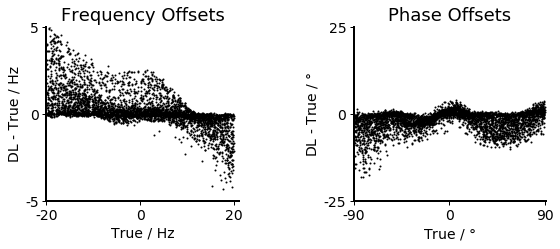

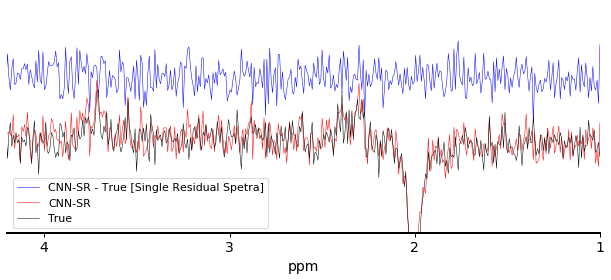

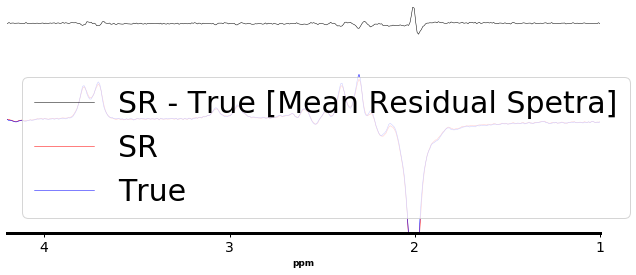

In [17]:
save_model_figurename1='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Figures/DLSR_wNoise1d5dB_wlb_scatterplot.png'
save_model_figurename2='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Figures/DLSR_wNoise1d5dB_wlb_DiffSpectra.png'


# defining residual offsets
F0_residual_offset_OFF=F0_testOFF.numpy()-np.transpose(prediction_F0_OFF)*-1
F0_residual_offset_ON=F0_testON.numpy()-np.transpose(prediction_F0_ON)*-1
Phs_residual_offset_OFF=Phs_testOFF.numpy()-np.transpose(prediction_Phs_OFF)*-1
Phs_residual_offset_ON=Phs_testON.numpy()-np.transpose(prediction_Phs_ON)*-1
F0_residual_offset=np.concatenate((F0_residual_offset_OFF,F0_residual_offset_ON),0)
Phs_residual_offset=np.concatenate((Phs_residual_offset_OFF,Phs_residual_offset_ON),0)

Fids_test=Fids[:,np.r_[18000:20000, 38000:40000]]

# JG: Fids and Spec for the Unaligned data
FidsUnAligned = np.empty((len(Fids_test[:,0]), len(Fids_test[0,:])), dtype = np.complex_)
FidsUnAlignedPhase = np.empty((len(Fids_test[:,0]), len(Fids_test[0,:])), dtype = np.complex_)
spectUnAligned = np.empty((len(Fids_test[:,0]), len(Fids_test[0,:])), dtype = np.complex_)
spectUnAlignedPhase = np.empty((len(Fids_test[:,0]), len(Fids_test[0,:])), dtype = np.complex_)

# JG: Spec for the Original data
# Is this used as ground truth?
spectAligned = np.empty((len(Fids_test[:,0]), len(Fids_test[0,:])), dtype = np.complex_)
spectAlignedPhase = np.empty((len(Fids_test[:,0]), len(Fids_test[0,:])), dtype = np.complex_)

for kk in range(len(Fids_test[0,:])):
    # get the single FID
    Fids_kk = Fids_test[:,kk]
    
    # get the phase and freq offsets
    phasePart = np.exp(-1j * Phs_residual_offset[kk] * cm.pi / 180)
    freqPart = np.exp(-1j * time * F0_residual_offset[kk] * 2 * cm.pi)
    correction = np.multiply(freqPart,phasePart)
    
    # apply the phase and freq offsets on the FID after LB
    FidsUnAligned[:,kk] = np.multiply(Fids_kk, correction) #[2048, 10000]
    FidsUnAlignedPhase[:,kk] = np.multiply(Fids_kk, phasePart) #[2048, 10000]
    
    # get the single spectra of the FID with freq and phase offsets and LB 
    spectUnAligned[:,kk] = fftshift(fft(FidsUnAligned[:,kk]))
    spectUnAlignedPhase[:,kk] = fftshift(fft(FidsUnAlignedPhase[:,kk]))
    
    # get the single spectra of the FID withOUT freq and phase offsets and LB 
    spectAligned[:,kk] = fftshift(fft(Fids_kk))
    spectAlignedPhase[:,kk] = fftshift(fft(Fids_kk))
    
    # get the Normalized single spectra of the FID with freq and phase offsets and LB 
    scale = np.max(np.squeeze(np.abs(spectUnAligned[:,kk])))
    spectUnAligned[:,kk] = spectUnAligned[:,kk]/scale
    scalePh = np.max(np.squeeze(np.abs(spectUnAlignedPhase[:,kk])))
    spectUnAlignedPhase[:,kk] = spectUnAlignedPhase[:,kk]/scalePh
    
    # get the Normalized single spectra of the FID withOUT freq and phase offsets and LB 
    scale = np.max(np.squeeze(np.abs(spectAligned[:,kk])))
    spectAligned[:,kk] = spectAligned[:,kk]/scale
    scalePh = np.max(np.squeeze(np.abs(spectAlignedPhase[:,kk])))
    spectAlignedPhase[:,kk] = spectAlignedPhase[:,kk]/scalePh


# %% Creating the validation figure
fontsize=14

plt.rcParams['axes.linewidth']=2 
plt.rcParams['lines.linewidth']=2 
plt.rcParams['font.size']='30'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

fig = plt.figure(figsize=(8.67, 4.4))

ax = plt.subplot(121)   
#plt.rc('axes', linewidth=1)

ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)     
ax.tick_params(width=1,color='k',length=4)
plt.yticks(np.arange(-5,5.1, step=5),['-5','0','5'], fontsize=fontsize)
plt.xticks(np.arange(-20,21,step=20),['-20','0','20'], fontsize=fontsize)
plt.ylabel('DL - True / Hz', fontname="Arial", fontsize=fontsize)
plt.xlabel('True / Hz', fontname="Arial", fontsize=fontsize)
plt.xlim((-20,21))
plt.ylim((-5, 5))
plt.plot(F0_testOFF.numpy(), np.squeeze(np.array(prediction_F0_OFF)*-1) - np.transpose(F0_testOFF.numpy()), 'ko', markersize=1)
plt.plot(F0_testON.numpy(), np.squeeze(np.array(prediction_F0_ON)*-1) - np.transpose(F0_testON.numpy()), 'ko', markersize=1)
plt.title('Frequency Offsets', fontname="Arial", fontsize=18)

t1 = np.mean(np.squeeze(np.array(prediction_F0_OFF)) - np.transpose(F0_testOFF.numpy()))
t2 = np.mean(np.squeeze(np.array(prediction_F0_ON)) - np.transpose(F0_testON.numpy()))
t3 = (t1 + t2)/2
e1 = np.std(np.squeeze(np.array(prediction_F0_OFF)) - np.transpose(F0_testOFF.numpy()))
e2 = np.std(np.squeeze(np.array(prediction_F0_ON)) - np.transpose(F0_testON.numpy()))
e3 = (e1 + e2)/2
print(r'$ {0:.2f} \pm {1:.2f} \/\degree$'.format(t3,e3))

rcParams['mathtext.default'] = 'regular'
#plt.text(-0.57*20,-0.13,r'$ {0:.2f} \pm {1:.2f} \/Hz$'.format(t3,e3),fontsize=9,fontname="Arial",color='black')
     
ax = plt.subplot(122)
plt.rcParams['axes.linewidth']=2 
plt.rcParams['lines.linewidth']=2 
plt.rcParams['font.size']='30'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)     
ax.tick_params(width=1,color='k',length=4)
plt.yticks(np.arange(-25,25.1,step=25),['-25','0','25'], fontsize=fontsize)
plt.xticks(np.arange(-90,91,step=90),['-90','0','90'], fontsize=fontsize)
plt.ylabel('DL - True /' r' $\degree $', fontname="Arial", fontsize=fontsize)
plt.xlabel('True / ' r'$\degree $', fontname="Arial", fontsize=fontsize)
plt.xlim((-90,91))
plt.ylim((-25, 25))
plt.plot(Phs_testOFF.numpy(), np.squeeze(np.array(prediction_Phs_OFF)*-1) - np.transpose(Phs_testOFF.numpy()), 'ko', markersize=1)
plt.plot(Phs_testON.numpy(), np.squeeze(np.array(prediction_Phs_ON)*-1) - np.transpose(Phs_testON.numpy()), 'ko', markersize=1)
plt.title('Phase Offsets', fontname="Arial", fontsize=18)

t1 = np.mean(np.squeeze(np.array(prediction_Phs_OFF)*-1) - Phs_testOFF.numpy())
t2 = np.mean(np.squeeze(np.array(prediction_Phs_ON)*-1) - Phs_testON.numpy())
t3 = (t1 + t2)/2
e1 = np.std(np.squeeze(np.array(prediction_Phs_OFF)*-1) - Phs_testOFF.numpy())
e2 = np.std(np.squeeze(np.array(prediction_Phs_ON)*-1) - Phs_testON.numpy())
e3 = (e1 + e2)/2
print(r'$ {0:.2f} \pm {1:.2f} \/\degree$'.format(t3,e3))
#plt.text(-0.72*90,-1.3,r'$ {0:.2f} \pm {1:.2f} \/\degree$'.format(t3,e3),fontsize=9,fontname="Arial",color='black')
plt.subplots_adjust(wspace=0.6,left=0.18, right=0.98, top=0.8, bottom=0.25)
plt.savefig(save_model_figurename1,format='png', dpi=300,bbox_inches='tight')  
    
freqRange = 2000/127.7
ppm = np.flip((np.arange(1,2048 + 1)) / 2048 * freqRange + 4.68 - freqRange/2)
xlim = [1, 4.2]

plt.rcParams['axes.linewidth']=2
plt.rcParams['lines.linewidth']=2 
plt.rcParams['font.size']='11'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

fig = plt.figure(figsize=(8.67, 4.5))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)   
ax.tick_params(width=1,color='k',length=4)
plt.xticks(np.arange(1,5,step=1), fontsize=fontsize)
ax.set_yticklabels([])
ax.axes.get_yaxis().set_visible(False)  

lw = 0.5
#spectAligned=np.transpose(spectAligned)
spectAlignedOFF=spectAligned[:,:2000]
spectAlignedON=spectAligned[:,2000:]

spectOFFCorrected=spectUnAligned[:,:2000]
spectONCorrected=spectUnAligned[:,2000:]

############################ Here #################################
k=9
spectONCorrected_real_single = spectONCorrected[:,k].real
spectOFFCorrected_real_single = spectOFFCorrected[:,k].real
spectAlignedON_real_single = spectAlignedON[:,k].real
spectAlignedOFF_real_single = spectAlignedOFF[:,k].real

plt.plot(ppm, spectONCorrected_real_single - spectOFFCorrected_real_single - (spectAlignedON_real_single - spectAlignedOFF_real_single) + 0.014,'b',linewidth=0.5)
plt.plot(ppm, spectONCorrected_real_single - spectOFFCorrected_real_single,'r',linewidth=lw)
plt.plot(ppm, spectAlignedON_real_single - spectAlignedOFF_real_single,'k',linewidth=lw)

plt.xlabel('ppm', fontname="Arial", fontsize=fontsize)
plt.xlim((xlim))
plt.gca().invert_xaxis()
plt.ylim((-0.02,0.03))
plt.legend(['CNN-SR - True [Single Residual Spetra]','CNN-SR','True'],loc="lower left")


plt.subplots_adjust(left=0.03, right=0.98, top=0.95,bottom=0.25)
plt.savefig(save_model_figurename2,format='png', dpi=300,bbox_inches='tight')  

plt.rcParams['axes.linewidth']=3 
plt.rcParams['lines.linewidth']=3 
plt.rcParams['font.size']='30'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

fig = plt.figure(figsize=(8.67, 4.5))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)   
ax.tick_params(width=1,color='k',length=4)
plt.xticks(np.arange(1,5,step=1), fontsize=fontsize)
ax.set_yticklabels([])
ax.axes.get_yaxis().set_visible(False)  

lw = 0.5
plt.plot(ppm, np.mean(spectONCorrected, axis=1).real - np.mean(spectOFFCorrected, axis=1).real - (np.mean(spectAlignedON, axis=1).real - np.mean(spectAlignedOFF, axis=1).real) + 0.017,'k',linewidth=0.5)
plt.plot(ppm, np.mean(spectONCorrected, axis=1).real - np.mean(spectOFFCorrected, axis=1).real,'r',linewidth=lw)
plt.plot(ppm, np.mean(spectAlignedON, axis=1).real - np.mean(spectAlignedOFF, axis=1).real,'b',linewidth=lw)

plt.xlabel('ppm', fontname="Arial", fontsize=9, fontweight='bold')
plt.xlim((xlim))
plt.gca().invert_xaxis()
plt.ylim((-0.02,0.02))
plt.legend(['SR - True [Mean Residual Spetra]','SR','True'],loc="lower left")
plt.subplots_adjust(left=0.03, right=0.98, top=0.95,bottom=0.25)
#plt.savefig(save_model_figurename2,format='png', dpi=300)  

### Diff AUC Percentage

In [19]:
import scipy
from scipy import integrate

freqRange = 2000/127.7
ppm = np.flip((np.arange(1,2048 + 1)) / 2048 * freqRange + 4.68 - freqRange/2)

GABA_Int = np.where((ppm <= 3.20) & (ppm >= 2.80))
Glx_Int= np.where((ppm >= 3.55) & (ppm <= 3.95))

################ GABA ##############################
spectDiffCorrected = spectONCorrected - spectOFFCorrected 
spectAlignedDiff = spectAlignedON - spectAlignedOFF

spectDiffCorrected_GABA=spectDiffCorrected[GABA_Int[0][0]:GABA_Int[0][-1]]
spectAlignedDiff_GABA=spectAlignedDiff[GABA_Int[0][0]:GABA_Int[0][-1]]

GABA_AUC=np.zeros((spectAlignedDiff_GABA.shape[1]))

for sample in range(len(GABA_AUC)):
    AUC_spectDiffCorrected_GABA=scipy.integrate.trapz(spectDiffCorrected_GABA[:,sample],ppm[GABA_Int[0][0]:GABA_Int[0][-1]])
    AUC_spectALignedDiff_GABA=scipy.integrate.trapz(spectAlignedDiff_GABA[:,sample],ppm[GABA_Int[0][0]:GABA_Int[0][-1]])
    GABA_AUC[sample]= abs(AUC_spectDiffCorrected_GABA.real-AUC_spectALignedDiff_GABA.real)/abs(AUC_spectALignedDiff_GABA.real)

GABA_AUC_mean=np.mean(GABA_AUC)
GABA_AUC_std=np.std(GABA_AUC)

print("Diff Spectra AUC GABA: ", GABA_AUC_mean, "+-", GABA_AUC_std)

################ Glx ##############################
spectDiffCorrected_Glx=spectDiffCorrected[Glx_Int[0][0]:Glx_Int[0][-1]]
spectAlignedDiff_Glx=spectAlignedDiff[Glx_Int[0][0]:Glx_Int[0][-1]]

Glx_AUC=np.zeros((spectAlignedDiff_Glx.shape[1]))

for sample in range(len(Glx_AUC)):
    AUC_spectDiffCorrected_Glx=scipy.integrate.trapz(spectDiffCorrected_Glx[:,sample],ppm[Glx_Int[0][0]:Glx_Int[0][-1]])
    AUC_spectALignedDiff_Glx=scipy.integrate.trapz(spectAlignedDiff_Glx[:,sample],ppm[Glx_Int[0][0]:Glx_Int[0][-1]])
    Glx_AUC[sample]= abs(AUC_spectDiffCorrected_Glx.real-AUC_spectALignedDiff_Glx.real)/abs(AUC_spectALignedDiff_Glx.real)

Glx_AUC_mean=np.mean(Glx_AUC)
Glx_AUC_std=np.std(Glx_AUC)

print("Diff Spectra AUC Glx: ", Glx_AUC_mean, "+-", Glx_AUC_std)

Diff Spectra AUC GABA:  1.6765521966635648 +- 9.559655188671364
Diff Spectra AUC Glx:  0.6743692313245415 +- 0.6541248246621589


In [20]:
# Diff Spectra
freqRange = 2000/127.7
ppm = np.flip((np.arange(1,2048 + 1)) / 2048 * freqRange + 4.68 - freqRange/2)

GABA_Int = np.where((ppm <= 3.20) & (ppm >= 2.80))
Glx_Int= np.where((ppm >= 3.55) & (ppm <= 3.95))

################ GABA ##############################
spectDiffCorrected = spectONCorrected - spectOFFCorrected 
spectAlignedDiff = spectAlignedON - spectAlignedOFF

spectDiffCorrected_GABA=spectDiffCorrected[GABA_Int[0][0]:GABA_Int[0][-1]]
spectAlignedDiff_GABA=spectAlignedDiff[GABA_Int[0][0]:GABA_Int[0][-1]]

spectDiff_residue_GABA = spectDiffCorrected_GABA - spectAlignedDiff_GABA
spectDiff_residue_MAE_mean_GABA = np.mean(np.mean(np.absolute(spectDiff_residue_GABA),axis=0))
spectDiff_residue_MAE_STD_GABA = np.std(np.mean(np.absolute(spectDiff_residue_GABA),axis=0))
print("GABA Mean Absolute Error: ", spectDiff_residue_MAE_mean_GABA, " +- ", spectDiff_residue_MAE_STD_GABA)

################ Glx ##############################
spectDiffCorrected_Glx=spectDiffCorrected[Glx_Int[0][0]:Glx_Int[0][-1]]
spectAlignedDiff_Glx=spectAlignedDiff[Glx_Int[0][0]:Glx_Int[0][-1]]

spectDiff_residue_Glx = spectDiffCorrected_Glx - spectAlignedDiff_Glx
spectDiff_residue_MAE_mean_Glx = np.mean(np.mean(np.absolute(spectDiff_residue_Glx),axis=0))
spectDiff_residue_MAE_STD_Glx = np.std(np.mean(np.absolute(spectDiff_residue_Glx),axis=0))
print("Glx Mean Absolute Error: ", spectDiff_residue_MAE_mean_Glx, " +- ", spectDiff_residue_MAE_STD_Glx)

GABA Mean Absolute Error:  0.004376832308690675  +-  0.0021448161981240665
Glx Mean Absolute Error:  0.004044894313919128  +-  0.001738381713739056


In [21]:
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_1d5dB_wLB_spectra_DIFF_Residual_GABA_MAE.npy', np.mean(np.absolute(spectDiff_residue_GABA),axis=0))
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_1d5dB_wLB_spectra_DIFF_Residual_Glx_MAE.npy', np.mean(np.absolute(spectDiff_residue_Glx),axis=0))

## **JET_CNN Testing optimization with Spectral Loss only (Semi-Supervised)**

Testing dataset unsupervised optmization begins...
==== Epoch: 1/1000 | testing_loss = 0.002606894305726701 | testing_correlation_R^2 = 0.8670105139781629 ====
==== Epoch: 1/1000 | testing_F0_MAE = 0.04794783059135079 Hz | testing_Phs_MAE = 0.318337584733963 Degree ====
Testing dataset unsupervised optmization begins...
==== Epoch: 2/1000 | testing_loss = 0.0026068917503443314 | testing_correlation_R^2 = 0.8670107540533076 ====
==== Epoch: 2/1000 | testing_F0_MAE = 0.047906691864132885 Hz | testing_Phs_MAE = 0.31799630196392537 Degree ====
best model loss is 0.00260689175034 at epoch 2
Testing dataset unsupervised optmization begins...
==== Epoch: 3/1000 | testing_loss = 0.002606890072990602 | testing_correlation_R^2 = 0.8670109062264347 ====
==== Epoch: 3/1000 | testing_F0_MAE = 0.047867951668798925 Hz | testing_Phs_MAE = 0.31775074963271616 Degree ====
best model loss is 0.00260689007299 at epoch 3
Testing dataset unsupervised optmization begins...
==== Epoch: 4/1000 | testing_loss =

KeyboardInterrupt: 

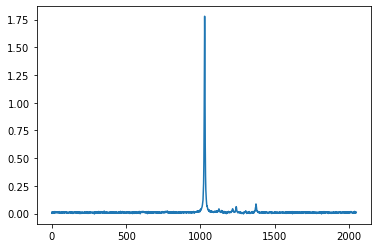

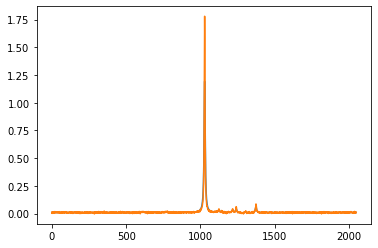

In [107]:
# define the model
JETCNN = JETCNN_L

# define loss and optimizer
criterion = MSELoss() #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_MSE_real + loss_MSE_imag)
#criterion = SmoothL1Loss() 
#criterion = MSELoss() 
lamda = 1

optimizer = Adam(JETCNN.parameters(),lr=1e-5)

# define parameters
EPOCHS = 1000

train_epoch_loss = []
train_epoch_F0_MAE = [] ##
train_epoch_Phs_MAE = [] ##
train_epoch_p_correlation = []

val_epoch_loss = []
val_epoch_F0_MAE = [] ##
val_epoch_Phs_MAE = [] ##
val_epoch_p_correlation = []
val_epoch_loss_input = []
val_epoch_p_correlation_input = []

test_epoch_loss = []
test_epoch_F0_MAE = [] ##
test_epoch_Phs_MAE = [] ##
test_epoch_p_correlation = []

# early stopping
early_stop = 0
patience = 50

# path
best_JETCNN_pretrained_path = '/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/SR_spectra_3dB/checkpoint_1d5dB_wLB_best_testing.pt'

best_JETCNN_path = '/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/SR_spectra_3dB/checkpoint_1d5dB_wLB_best_testing.pt'
last_JETCNN_path = '/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/SR_spectra_3dB/checkpoint_1d5dB_wLB_last_testing.pt'

# Loading pretrained model 
JETCNN.load_state_dict(torch.load(best_JETCNN_pretrained_path))

# where to calculate the spectral loss
range1 = 0
range2 = 2048

fid_range1 = 0
fid_range2 = 1024 #try 1024
    
for epoch in range(EPOCHS):
     
    train_loss = []
    train_F0_MAE = [] ##
    train_Phs_MAE = [] ##
    train_p_correlation = []
    
    val_loss = []
    val_F0_MAE = [] ##
    val_Phs_MAE = [] ##
    val_p_correlation = []
    
    test_loss = []
    test_F0_MAE = [] ##
    test_Phs_MAE = [] ##
    test_p_correlation = []
    
    val_loss_input = []
    val_p_correlation_input = []

    #######################################################
    ####################### Train #########################
    #######################################################
    print('Testing dataset unsupervised optmization begins...')
    for batch_index, data in enumerate(test_loader):
        #print(batch_index)
        # If GPU is available, move the data to the GPU for faster computation.
        if cuda:
            # *** get the inputs; data is a list of [noisy_Real_spectUnAligned_tensor, Real_FidsAligned_tensor, Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor, F0_tensor,Phs_tensor]
            noisy_Real_spectUnAligned_and_spectAligned_tensor, Real_FidsAligned_tensor, Imag_FidsAligned_tensor =  data[0].to(device), data[1].to(device), data[2].to(device)
            Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor = data[3].to(device), data[4].to(device), data[5].to(device)
            F0_tensor, Phs_tensor = data[6].to(device), data[7].to(device) ##
            
            #print('noisy_Real_spectUnAligned_tensor',noisy_Real_spectUnAligned_tensor.shape)
            #print('Real_FidsAligned_tensor',Real_FidsAligned_tensor.shape)
            #print('Real_FidsUnAligned_tensor',Real_FidsUnAligned_tensor.shape)
            #print('Imag_FidsUnAligned_tensor',Imag_FidsUnAligned_tensor.shape)
            #print('time_mat_tensor',time_mat_tensor.shape)
            
            # *** Set the model to train mode ***
            JETCNN.train()
            
            # *** zero the parameter gradients ***
            optimizer.zero_grad()
            
            # *** forward + backward + optimize ***
            
            #predict deformation from real spectra unaligned and aligned
            
            
            deformation_predicted = JETCNN(noisy_Real_spectUnAligned_and_spectAligned_tensor)
            
            #cloning real and imag fids unaligned tensor
            Real_FidsAligned_pred_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_FidsAligned_pred_tensor = torch.clone(Imag_FidsUnAligned_tensor)
            
            Real_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Real_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            
            # *** Define loss between the real part of deformed spectra and the real part of the true spectra
            
            # cloning the ground truths (initializing)
            F0_pred_tensor = torch.clone(F0_tensor)
            Phs_pred_tensor = torch.clone(Phs_tensor)
            
            for kk in range(len(deformation_predicted[:,0])):
                
                # exp(ix) = cos(x) + i*sin(x)
                #freqPart = np.exp(-1j * time * F0[kk] * 2 * cm.pi)
                #phasePart = np.exp(-1j * Phs[kk] * cm.pi / 180)
                
                #introducing real deformations
                freqPart_real = torch.cos(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
                phasePart_real = torch.cos(-1 * deformation_predicted[kk,1] * cm.pi / 180)
                
                #introducing imaginary deformations
                freqPart_imag = torch.sin(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
                phasePart_imag = torch.sin(-1 * deformation_predicted[kk,1] * cm.pi / 180)
                
                #defining deformations from the offsets
                deformation_real = torch.mul(freqPart_real,phasePart_real) - torch.mul(freqPart_imag,phasePart_imag)
                deformation_imag = torch.mul(freqPart_real,phasePart_imag) + torch.mul(freqPart_imag,phasePart_real)
                
                #constructing tensor for the deformations
                F0_pred_tensor[kk] = deformation_predicted[kk,0] ##
                Phs_pred_tensor[kk] = deformation_predicted[kk,1] ##
                
                #print(F0_pred_tensor[kk]-F0_tensor[kk])
                #print(Phs_pred_tensor[kk]-Phs_tensor[kk])
                
                #contructing real and imaging fids prediction tensor
                Real_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_real
                                                                ) - torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_imag)
                Imag_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_imag
                                                                ) + torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_real)
                
                Real_pred_spec_tensor[kk,:,:] = torch.real(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))
                Imag_pred_spec_tensor[kk,:,:] = torch.imag(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))
                
                Real_spec_tensor[kk,:,:] = torch.real(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
                Imag_spec_tensor[kk,:,:] = torch.imag(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            
            #def complex_mul(x, y):
            #xr, xi = tf.real(x), tf.imag(x)
            #yr, yi = tf.real(y), tf.imag(y)
            #return tf.complex(xr*yr - xi*yi, xr*yi + xi*yr)
            
            # flattening
            F0_pred_tensor_vector = torch.flatten(F0_pred_tensor) ##
            F0_tensor_vector = torch.flatten(F0_tensor) ##
            Phs_pred_tensor_vector = torch.flatten(Phs_pred_tensor) ##
            Phs_tensor_vector = torch.flatten(Phs_tensor) ##
             
            # defining fids real and imag predicted and truth tensors
            Real_FidsAligned_pred_tensor_vector = torch.flatten(Real_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
            Real_FidsAligned_tensor_vector = torch.flatten(Real_FidsAligned_tensor[:,:,fid_range1:fid_range2])
            
            Imag_FidsAligned_pred_tensor_vector = torch.flatten(Imag_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
            Imag_FidsAligned_tensor_vector = torch.flatten(Imag_FidsAligned_tensor[:,:,fid_range1:fid_range2])
            
            # specs
            Real_pred_spec_tensor_vector = torch.flatten(Real_pred_spec_tensor[:,:,range1:range2])
            Real_spec_tensor_vector = torch.flatten(Real_spec_tensor[:,:,range1:range2])
            
            Imag_pred_spec_tensor_vector = torch.flatten(Imag_pred_spec_tensor[:,:,range1:range2])
            Imag_spec_tensor_vector = torch.flatten(Imag_spec_tensor[:,:,range1:range2])
            
            # if epoch<=100: use the initial predefined template; if epoch>100: update the template (real_template=median(real_spectra_corrected))
            
            #predicted f0 and ph and truth f0 and phs loss computation
            loss_MAE_F0 = criterion(F0_pred_tensor_vector, torch.mul(F0_tensor_vector,-1)) 
            loss_MAE_Ph = criterion(Phs_pred_tensor_vector, torch.mul(Phs_tensor_vector,-1)) 
            
            #predicted and truth fids loss computation
            loss_fid_MSE_real = criterion(Real_FidsAligned_pred_tensor_vector, Real_FidsAligned_tensor_vector) 
            loss_fid_MSE_imag = criterion(Imag_FidsAligned_pred_tensor_vector, Imag_FidsAligned_tensor_vector)
            
            #predicted and truth spectra loss computation
            loss_spec_MSE_real = criterion(Real_pred_spec_tensor_vector, Real_spec_tensor_vector) 
            loss_spec_MSE_imag = criterion(Imag_pred_spec_tensor_vector, Imag_spec_tensor_vector)
            
            # fids correlation loss real and imag
            v_Real_pred_fid = Real_FidsAligned_pred_tensor_vector - torch.mean(Real_FidsAligned_pred_tensor_vector)
            v_Real_fid = Real_FidsAligned_tensor_vector - torch.mean(Real_FidsAligned_tensor_vector)
            p_correlation_real = torch.sum(v_Real_pred_fid * v_Real_fid) / (torch.sqrt(torch.sum(v_Real_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Real_fid ** 2)))
            loss_p_correlation_real = 1-torch.mul(p_correlation_real,p_correlation_real)
            #print('loss_p_correlation_real',loss_p_correlation_real)
            v_Imag_pred_fid = Imag_FidsAligned_pred_tensor_vector - torch.mean(Imag_FidsAligned_pred_tensor_vector)
            v_Imag_fid = Imag_FidsAligned_tensor_vector - torch.mean(Imag_FidsAligned_tensor_vector)
            p_correlation_imag = torch.sum(v_Imag_pred_fid * v_Imag_fid) / (torch.sqrt(torch.sum(v_Imag_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Imag_fid ** 2)))
            loss_p_correlation_imag = 1-torch.mul(p_correlation_imag,p_correlation_imag)
            #print('loss_p_correlation_imag',loss_p_correlation_imag)
            
            # spectra correlation loss real and imag
            v_Real_pred_spec = Real_pred_spec_tensor_vector - torch.mean(Real_pred_spec_tensor_vector)
            v_Real_spec = Real_spec_tensor_vector - torch.mean(Real_spec_tensor_vector)
            spec_p_correlation_real = torch.sum(v_Real_pred_spec * v_Real_spec) / (torch.sqrt(torch.sum(v_Real_pred_spec ** 2)) * torch.sqrt(torch.sum(v_Real_spec ** 2)))
            spec_loss_p_correlation_real = 1-torch.mul(spec_p_correlation_real,spec_p_correlation_real)
            #print('loss_p_correlation_real',loss_p_correlation_real)
            v_Imag_pred_spec = Imag_pred_spec_tensor_vector - torch.mean(Imag_pred_spec_tensor_vector)
            v_Imag_spec = Imag_spec_tensor_vector - torch.mean(Imag_spec_tensor_vector)
            spec_p_correlation_imag = torch.sum(v_Imag_pred_spec * v_Imag_spec) / (torch.sqrt(torch.sum(v_Imag_pred_spec ** 2)) * torch.sqrt(torch.sum(v_Imag_spec ** 2)))
            spec_loss_p_correlation_imag = 1-torch.mul(spec_p_correlation_imag,spec_p_correlation_imag)
            #print('loss_p_correlation_imag',loss_p_correlation_imag)
            
            #loss = loss_MSE_real + loss_MSE_imag 
            #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)
            #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/10)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)
            
            #overall loss computation
            #loss = (lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)
            #loss = (lamda)*(loss_spec_MSE_real + loss_spec_MSE_imag)+(1-lamda)*(spec_loss_p_correlation_real + spec_loss_p_correlation_imag)
            
            loss = loss_spec_MSE_real + loss_spec_MSE_imag  # spectral loss only

            
            # compute the MAE of the tensors                             Check!
            F0_MAE = torch.abs(F0_pred_tensor_vector + F0_tensor_vector).mean().data  ##
            Phs_MAE = torch.abs(Phs_pred_tensor_vector + Phs_tensor_vector).mean().data  ##
            
            # compute the fids real and imag
            fid_pred_real = torch.flatten(torch.mean(Real_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
            fid_real = torch.flatten(torch.mean(Real_FidsAligned_tensor,0)).cpu().detach().numpy()
            fid_pred_imag = torch.flatten(torch.mean(Imag_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
            fid_imag = torch.flatten(torch.mean(Imag_FidsAligned_tensor,0)).cpu().detach().numpy()
            
            #real spectra and predicted spectra
            Real_pred_spec = np.real(fftshift(fft(fid_pred_real+1j*fid_pred_imag)))
            Real_spec = np.real(fftshift(fft(fid_real+1j*fid_imag)))
            
            #correlation of spectras
            r = np.corrcoef(Real_pred_spec[range1:range2],Real_spec[range1:range2])
            p_correlation = r[0,1]
            #print('p_correlation',p_correlation)
            
            if epoch == 100 and batch_index == 1:
                plt.figure()
                plt.plot(Real_spec[range1:range2])
                plt.figure()
                plt.plot(Real_pred_spec[range1:range2])
                plt.plot(Real_spec[range1:range2])

            # backpropagate the loss
            loss.backward()
            # update the parameters
            optimizer.step()
            
            # store the train_loss and tran_p_correlation
            train_loss.append(loss.cpu().data.item())
            train_F0_MAE.append(F0_MAE.cpu().data.item()) ##
            train_Phs_MAE.append(Phs_MAE.cpu().data.item()) ##
            train_p_correlation.append(p_correlation)
    
    
    train_epoch_loss.append(np.mean(train_loss))
    train_epoch_F0_MAE.append(np.mean(train_F0_MAE)) ##
    train_epoch_Phs_MAE.append(np.mean(train_Phs_MAE)) ##
    train_epoch_p_correlation.append(np.mean(train_p_correlation))
    
    
    print("==== Epoch: {}/{} | testing_loss = {} | testing_correlation_R^2 = {} ====".format(epoch+1, EPOCHS, train_epoch_loss[-1], \
                                                                                         train_epoch_p_correlation[-1]*train_epoch_p_correlation[-1]))
    print("==== Epoch: {}/{} | testing_F0_MAE = {} Hz | testing_Phs_MAE = {} Degree ====".format(epoch+1, EPOCHS, train_epoch_F0_MAE[-1], \
                                                                                         train_epoch_Phs_MAE[-1]))
    
    #if epoch == 0:
    #    print("==== Epoch: {}/{} | val_loss_input = {} | val_p_correlation_input^2 = {} ====".format(epoch, EPOCHS, val_epoch_loss_input[-1], \
    #                                                                                             val_epoch_p_correlation_input[-1]*val_epoch_p_correlation_input[-1]))
    print("=======================================================================================================================")
    
    
    # save models
    #torch.save(JETCNN.state_dict(), './JETCNNmodel_SR_1.25dB/checkpoint_epoch_%s.pkl' % (epoch))
    
    # Make sure we save the best and last unets.
    if epoch == 0:
        best_JETCNN_loss = train_epoch_loss[0]
    if train_epoch_loss[-1] < best_JETCNN_loss:
        best_JETCNN_loss = train_epoch_loss[-1]
        best_epoch = epoch
        best_JETCNN = JETCNN.state_dict()
        print(f'best model loss is {best_JETCNN_loss:0.14f} at epoch {epoch+1}' )
        torch.save(best_JETCNN, best_JETCNN_path)
    if (epoch == EPOCHS - 1):
        last_JETCNN = JETCNN.state_dict()
        torch.save(last_JETCNN, last_JETCNN_path)

    # Early stop 
    if (early_stop == 1):
        if (len(val_epoch_loss) > patience):
            if (np.min(val_epoch_loss[0:-patience+1]) <= np.min(val_epoch_loss[-patience:])):
                print('Validation loss stop decreasing. Stop training.')
                last_JETCNN = JETCNN.state_dict()
                torch.save(last_JETCNN, last_JETCNN_path)
                break  

### **Evaluation**

#### OFF

In [19]:
# ============ testing dataset ============
N_test = 2000
time_mat_test = np.tile(time,[N_test,1])

#defining ground truths
F0_test = F0_all[18000:20000] 
Phs_test = Phs_all[18000:20000] 

#defining spectras and fids
noisy_Real_spectUnAligned_and_spectAligned_tensor_test = noisy_Real_spectUnAligned_and_spectAligned_tensor_all[18000:20000,:,:]

Real_FidsAligned_tensor_test = Real_FidsAligned_tensor_all[18000:20000,:,:]

Imag_FidsAligned_tensor_test = Imag_FidsAligned_tensor_all[18000:20000,:,:]

Real_FidsUnAligned_tensor_test = Real_FidsUnAligned_tensor_all[18000:20000,:,:]

Imag_FidsUnAligned_tensor_test = Imag_FidsUnAligned_tensor_all[18000:20000,:,:]

time_mat_tensor_test = torch.from_numpy(time_mat_test).type(torch.FloatTensor).view(-1, 1, 2048) # Imag part of Dard Red

#defining test loader
test_data = TensorDataset(noisy_Real_spectUnAligned_and_spectAligned_tensor_test, Real_FidsAligned_tensor_test, Imag_FidsAligned_tensor_test, Real_FidsUnAligned_tensor_test, \
                           Imag_FidsUnAligned_tensor_test, time_mat_tensor_test, F0_test, Phs_test)
test_loader = DataLoader(test_data, batch_size = 1)

#printing outputs
print('time_mat_tensor_test',time_mat_tensor_test.shape)
print('F0_test',F0_test.shape)
print('Phs_test',Phs_test.shape)

time_mat_tensor_test torch.Size([2000, 1, 2048])
F0_test torch.Size([2000])
Phs_test torch.Size([2000])


In [20]:
# ============ testing dataset ============
N_test = 2000
time_mat_test = np.tile(time,[N_test,1])

#defining ground truths
F0_test = F0_all[18000:20000]
Phs_test = Phs_all[18000:20000]

#defining spectras and fids
noisy_Real_spectUnAligned_and_spectAligned_tensor_test = noisy_Real_spectUnAligned_and_spectAligned_tensor_all[18000:20000,:,:]

Real_FidsAligned_tensor_test = Real_FidsAligned_tensor_all[18000:20000,:,:]

Imag_FidsAligned_tensor_test = Imag_FidsAligned_tensor_all[18000:20000,:,:]

Real_FidsUnAligned_tensor_test = Real_FidsUnAligned_tensor_all[18000:20000,:,:]

Imag_FidsUnAligned_tensor_test = Imag_FidsUnAligned_tensor_all[18000:20000,:,:]

time_mat_tensor_test = torch.from_numpy(time_mat_test).type(torch.FloatTensor).view(-1, 1, 2048) # Imag part of Dard Red

#defining test loader
test_data = TensorDataset(noisy_Real_spectUnAligned_and_spectAligned_tensor_test, Real_FidsAligned_tensor_test, Imag_FidsAligned_tensor_test, Real_FidsUnAligned_tensor_test, \
                           Imag_FidsUnAligned_tensor_test, time_mat_tensor_test, F0_test, Phs_test)
test_loader = DataLoader(test_data, batch_size = 1)

#printing outputs
print('time_mat_tensor_test',time_mat_tensor_test.shape)
print('F0_test',F0_test.shape)
print('Phs_test',Phs_test.shape)


time_mat_tensor_test torch.Size([2000, 1, 2048])
F0_test torch.Size([2000])
Phs_test torch.Size([2000])


In [21]:
# define the model
model_n = '/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/SR_spectra_3dB/checkpoint_1d5dB_wLB_best_testing.pt'

data_save_F0='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/SR_Spectra_1d5dB_wLB_testing_finetuned_F0_OFF_pred.npy'
data_save_Phs='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/SR_Spectra_1d5dB_wLB_testing_finetuned_Phs_OFF_pred.npy'

JETCNN = JETCNN_L
JETCNN.load_state_dict(torch.load(model_n))
# define loss and optimizer
#criterion = L1Loss() #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_MSE_real + loss_MSE_imag)
#criterion = SmoothL1Loss() 
criterion = L1Loss() 
lamda = 1

#optimizer = Adam(JETCNN.parameters(),lr=1e-4)
test_epoch_loss = []
test_epoch_F0_MAE = [] ##
test_epoch_Phs_MAE = [] ##
test_epoch_F0_SD=[]
test_epoch_Phs_SD=[]
test_epoch_p_correlation = []
F0_ON_predicted=[]
Phs_ON_predicted=[]

# where to calculate the spectral loss
range1 = 1100
range2 = 1500

fid_range1 = 0
fid_range2 = 512
    
test_loss = []
test_F0_MAE = [] ##
test_Phs_MAE = [] ##
test_F0_SD=[]
test_Phs_SD=[]
test_F0_pred=[]
test_Phs_pred=[]
test_p_correlation = []

#######################################################
######################## Test #########################
#######################################################
print('Testing begins...')
for batch_index, data in enumerate(test_loader):
    # If GPU is available, move the data to the GPU for faster computation.
    if cuda:
        # *** get the inputs; data is a list of [noisy_Real_spectUnAligned_tensor, Real_FidsAligned_tensor, Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor]
        noisy_Real_spectUnAligned_and_spectAligned_tensor, Real_FidsAligned_tensor, Imag_FidsAligned_tensor =  data[0].to(device), data[1].to(device), data[2].to(device)
        Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor = data[3].to(device), data[4].to(device), data[5].to(device)
        F0_tensor, Phs_tensor = data[6].to(device), data[7].to(device) ##

        #print('noisy_Real_spectUnAligned_tensor',noisy_Real_spectUnAligned_tensor.shape)
        #print('Real_FidsAligned_tensor',Real_FidsAligned_tensor.shape)
        #print('Real_FidsUnAligned_tensor',Real_FidsUnAligned_tensor.shape)
        #print('Imag_FidsUnAligned_tensor',Imag_FidsUnAligned_tensor.shape)
        #print('time_mat_tensor',time_mat_tensor.shape)

        # *** Set the model to train mode ***
        JETCNN.train()
        
        # *** forward + backward + optimize ***
        deformation_predicted = JETCNN(noisy_Real_spectUnAligned_and_spectAligned_tensor)

        Real_FidsAligned_pred_tensor = torch.clone(Real_FidsUnAligned_tensor)
        Imag_FidsAligned_pred_tensor = torch.clone(Imag_FidsUnAligned_tensor)

        #Real_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
        #Imag_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
        #Real_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
        #Imag_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)

        # *** Define loss between the real part of deformed spectra and the real part of the true spectra
        # apply the deformation
        F0_pred_tensor = torch.clone(F0_tensor)
        Phs_pred_tensor = torch.clone(Phs_tensor)
        for kk in range(len(deformation_predicted[:,0])):

            # exp(ix) = cos(x) + i*sin(x)
            #freqPart = np.exp(-1j * time * F0[kk] * 2 * cm.pi)
            #phasePart = np.exp(-1j * Phs[kk] * cm.pi / 180)

            freqPart_real = torch.cos(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
            phasePart_real = torch.cos(-1 * deformation_predicted[kk,1] * cm.pi / 180)

            freqPart_imag = torch.sin(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
            phasePart_imag = torch.sin(-1 * deformation_predicted[kk,1] * cm.pi / 180)

            deformation_real = torch.mul(freqPart_real,phasePart_real) - torch.mul(freqPart_imag,phasePart_imag)
            deformation_imag = torch.mul(freqPart_real,phasePart_imag) + torch.mul(freqPart_imag,phasePart_real)
                
            F0_pred_tensor[kk] = deformation_predicted[kk,0] ##
            Phs_pred_tensor[kk] = deformation_predicted[kk,1] ##

            #print(F0_pred_tensor[kk]-F0_tensor[kk])
            #print(Phs_pred_tensor[kk]-Phs_tensor[kk])

            Real_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_real
                                                            ) - torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_imag)
            Imag_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_imag
                                                            ) + torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_real)

            #pred_spec_tensor = torch.fftshift(torch.fft(torch.cat(Real_FidsAligned_pred_tensor[kk,:,:],Imag_FidsAligned_pred_tensor[kk,:,:])))
            #Real_pred_spec_tensor[kk,:,:] = torch.fftshift(torch.fft(torch.cat(Real_FidsAligned_pred_tensor[kk,:,:],Imag_FidsAligned_pred_tensor[kk,:,:])))
            #Imag_pred_spec_tensor[kk,:,:] = torch.imag(torch.fftshift(torch.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))

            #Real_spec_tensor[kk,:,:] = torch.real(torch.fftshift(torch.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            #Imag_spec_tensor[kk,:,:] = torch.imag(torch.fftshift(torch.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            F0_ON_predicted.append(deformation_predicted[kk,0])
            Phs_ON_predicted.append(deformation_predicted[kk,1])

        #def complex_mul(x, y):
        #xr, xi = tf.real(x), tf.imag(x)
        #yr, yi = tf.real(y), tf.imag(y)
        #return tf.complex(xr*yr - xi*yi, xr*yi + xi*yr)

        # compute the loss
        F0_pred_tensor_vector = torch.flatten(F0_pred_tensor) ##
        F0_tensor_vector = torch.flatten(F0_tensor) ##
        Phs_pred_tensor_vector = torch.flatten(Phs_pred_tensor) ##
        Phs_tensor_vector = torch.flatten(Phs_tensor) ##

        # fids
        Real_FidsAligned_pred_tensor_vector = torch.flatten(Real_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
        Real_FidsAligned_tensor_vector = torch.flatten(Real_FidsAligned_tensor[:,:,fid_range1:fid_range2])

        Imag_FidsAligned_pred_tensor_vector = torch.flatten(Imag_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
        Imag_FidsAligned_tensor_vector = torch.flatten(Imag_FidsAligned_tensor[:,:,fid_range1:fid_range2])

        # specs
        #Real_pred_spec_tensor_vector = torch.flatten(Real_pred_spec_tensor[:,:,range1:range2])
        #Real_spec_tensor_vector = torch.flatten(Real_spec_tensor[:,:,range1:range2])

        #Imag_pred_spec_tensor_tensor_vector = torch.flatten(Imag_pred_spec_tensor[:,:,range1:range2])
        #Imag_spec_tensor_vector = torch.flatten(Imag_spec_tensor[:,:,range1:range2])

        # if epoch<=100: use the initial predefined template; if epoch>100: update the template (real_template=median(real_spectra_corrected))
        loss_MAE_F0 = criterion(F0_pred_tensor_vector, torch.mul(F0_tensor_vector,-1)) 
        loss_MAE_Ph = criterion(Phs_pred_tensor_vector, torch.mul(Phs_tensor_vector,-1)) 

        loss_fid_MSE_real = criterion(Real_FidsAligned_pred_tensor_vector, Real_FidsAligned_tensor_vector) 
        loss_fid_MSE_imag = criterion(Imag_FidsAligned_pred_tensor_vector, Imag_FidsAligned_tensor_vector)

    #loss_spec_MSE_real = criterion(Real_pred_spec_tensor_vector, Real_spec_tensor_vector) 
    #loss_spec_MSE_imag = criterion(Imag_pred_spec_tensor_tensor_vector, Imag_spec_tensor_vector)

        # fid correlation loss
        v_Real_pred_fid = Real_FidsAligned_pred_tensor_vector - torch.mean(Real_FidsAligned_pred_tensor_vector)
        v_Real_fid = Real_FidsAligned_tensor_vector - torch.mean(Real_FidsAligned_tensor_vector)
        p_correlation_real = torch.sum(v_Real_pred_fid * v_Real_fid) / (torch.sqrt(torch.sum(v_Real_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Real_fid ** 2)))
        loss_p_correlation_real = 1-torch.mul(p_correlation_real,p_correlation_real)
        #print('loss_p_correlation_real',loss_p_correlation_real)

        v_Imag_pred_fid = Imag_FidsAligned_pred_tensor_vector - torch.mean(Imag_FidsAligned_pred_tensor_vector)
        v_Imag_fid = Imag_FidsAligned_tensor_vector - torch.mean(Imag_FidsAligned_tensor_vector)
        p_correlation_imag = torch.sum(v_Imag_pred_fid * v_Imag_fid) / (torch.sqrt(torch.sum(v_Imag_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Imag_fid ** 2)))
        loss_p_correlation_imag = 1-torch.mul(p_correlation_imag,p_correlation_imag) # Correlation loss = 1-R^2 
        #print('loss_p_correlation_imag',loss_p_correlation_imag)

        #loss = loss_MSE_real + loss_MSE_imag 
        #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)
        #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/10)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)
        loss = (lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)

        # compute the MAE of 
        F0_MAE = torch.abs(F0_pred_tensor_vector + F0_tensor_vector).mean().data  ##
        Phs_MAE = torch.abs(Phs_pred_tensor_vector + Phs_tensor_vector).mean().data  ##

        # compute the correlation
        fid_pred_real = torch.flatten(torch.mean(Real_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
        fid_real = torch.flatten(torch.mean(Real_FidsAligned_tensor,0)).cpu().detach().numpy()
        fid_pred_imag = torch.flatten(torch.mean(Imag_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
        fid_imag = torch.flatten(torch.mean(Imag_FidsAligned_tensor,0)).cpu().detach().numpy()

        Real_pred_spec = np.real(fftshift(fft(fid_pred_real+1j*fid_pred_imag)))
        Real_spec = np.real(fftshift(fft(fid_real+1j*fid_imag)))

        r = np.corrcoef(Real_pred_spec[range1:range2],Real_spec[range1:range2])
        p_correlation = r[0,1]
        #print('p_correlation',p_correlation)

        #v_Real_pred_spec = Real_pred_spec[range1:range2] - np.mean(Real_pred_spec[range1:range2])
        #v_Real_spec = Real_spec[range1:range2] - np.mean(Real_spec[range1:range2])
        #p_correlation = np.sum(v_Real_pred_spec * v_Real_spec) / (np.sqrt(np.sum(Real_pred_spec ** 2)) * np.sqrt(np.sum(v_Real_spec ** 2)))

        # store the train_loss and tran_p_correlation
        test_F0_pred.append(F0_pred_tensor_vector.cpu().data.item())
        test_Phs_pred.append(Phs_pred_tensor_vector.cpu().data.item())
        test_loss.append(loss.cpu().data.item())
        test_F0_MAE.append(F0_MAE.cpu().data.item()) ##
        test_Phs_MAE.append(Phs_MAE.cpu().data.item()) ##
        test_p_correlation.append(p_correlation)
np.save(data_save_F0, test_F0_pred)
np.save(data_save_Phs,test_Phs_pred)
test_epoch_loss.append(np.mean(test_loss))
test_epoch_F0_MAE.append(np.mean(test_F0_MAE)) ##
test_epoch_Phs_MAE.append(np.mean(test_Phs_MAE)) ##
test_epoch_F0_SD.append(np.std(test_F0_MAE)) ##
test_epoch_Phs_SD.append(np.std(test_Phs_MAE)) ##
test_epoch_p_correlation.append(np.mean(test_p_correlation))
#print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))

print("---------------------------------------------------------------------------------------------------------------------")
print(" test_loss = {} | test_p_correlation^2 = {} ====".format(test_epoch_loss[-1], \
                                                                                 test_epoch_p_correlation[-1]*test_epoch_p_correlation[-1]))
print(" test_F0_MAE = {} +- {} Hz | test_Phs_MAE = {} +- {} Degree ====".format(test_epoch_F0_MAE[-1],test_epoch_F0_SD[-1], \
                                                                                     test_epoch_Phs_MAE[-1],test_epoch_Phs_SD[-1]))

#if epoch == 0:
#    print("==== Epoch: {}/{} | val_loss_input = {} | val_p_correlation_input^2 = {} ====".format(epoch, EPOCHS, val_epoch_loss_input[-1], \
#                                                                                             val_epoch_p_correlation_input[-1]*val_epoch_p_correlation_input[-1]))
print("=======================================================================================================================")

prediction_F0_OFF=test_F0_pred
prediction_Phs_OFF=test_Phs_pred

Testing begins...
---------------------------------------------------------------------------------------------------------------------
 test_loss = 0.0020659461424002074 | test_p_correlation^2 = 0.7904320492795687 ====
 test_F0_MAE = 0.057804234275594356 +- 0.050331929474720816 Hz | test_Phs_MAE = 0.4157604534365237 +- 0.31746532471561584 Degree ====


In [25]:
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_Refined_1d5dB_wLB_F0_OFF_MAE.npy', test_F0_MAE)
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_Refined_1d5dB_wLB_Phs_OFF_MAE.npy', test_Phs_MAE)

In [22]:
# ============ testing dataset ============
N_test = 2000
time_mat_test = np.tile(time,[N_test,1])

#defining ground truths
F0_test = F0_all[38000:40000]
Phs_test = Phs_all[38000:40000]

#defining spectras and fids
noisy_Real_spectUnAligned_and_spectAligned_tensor_test = noisy_Real_spectUnAligned_and_spectAligned_tensor_all[38000:40000,:,:]

Real_FidsAligned_tensor_test = Real_FidsAligned_tensor_all[38000:40000,:,:]

Imag_FidsAligned_tensor_test = Imag_FidsAligned_tensor_all[38000:40000,:,:]

Real_FidsUnAligned_tensor_test = Real_FidsUnAligned_tensor_all[38000:40000,:,:]

Imag_FidsUnAligned_tensor_test = Imag_FidsUnAligned_tensor_all[38000:40000,:,:]

time_mat_tensor_test = torch.from_numpy(time_mat_test).type(torch.FloatTensor).view(-1, 1, 2048) # Imag part of Dard Red

#defining test loader
test_data = TensorDataset(noisy_Real_spectUnAligned_and_spectAligned_tensor_test, Real_FidsAligned_tensor_test, Imag_FidsAligned_tensor_test, Real_FidsUnAligned_tensor_test, \
                           Imag_FidsUnAligned_tensor_test, time_mat_tensor_test, F0_test, Phs_test)
test_loader = DataLoader(test_data, batch_size = 1)

#printing outputs
print('time_mat_tensor_test',time_mat_tensor_test.shape)
print('F0_test',F0_test.shape)
print('Phs_test',Phs_test.shape)


time_mat_tensor_test torch.Size([2000, 1, 2048])
F0_test torch.Size([2000])
Phs_test torch.Size([2000])


In [23]:
# define the model
model_n = '/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/SR_spectra_3dB/checkpoint_1d5dB_wLB_best_testing.pt'

data_save_F0='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/SR_Spectra_1d5dB_wLB_testing_finetuned_F0_ON_pred.npy'
data_save_Phs='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/SR_Spectra_1d5dB_wLB_testing_finetuned_Phs_ON_pred.npy'

JETCNN = JETCNN_L
JETCNN.load_state_dict(torch.load(model_n))
# define loss and optimizer
#criterion = L1Loss() #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_MSE_real + loss_MSE_imag)
#criterion = SmoothL1Loss() 
criterion = L1Loss() 
lamda = 1

#optimizer = Adam(JETCNN.parameters(),lr=1e-4)
test_epoch_loss = []
test_epoch_F0_MAE = [] ##
test_epoch_Phs_MAE = [] ##
test_epoch_F0_SD=[]
test_epoch_Phs_SD=[]
test_epoch_p_correlation = []
F0_ON_predicted=[]
Phs_ON_predicted=[]

# where to calculate the spectral loss
range1 = 1100
range2 = 1500

fid_range1 = 0
fid_range2 = 512
    
test_loss = []
test_F0_MAE = [] ##
test_Phs_MAE = [] ##
test_F0_SD=[]
test_Phs_SD=[]
test_F0_pred=[]
test_Phs_pred=[]
test_p_correlation = []

#######################################################
######################## Test #########################
#######################################################
print('Testing begins...')
for batch_index, data in enumerate(test_loader):
    # If GPU is available, move the data to the GPU for faster computation.
    if cuda:
        # *** get the inputs; data is a list of [noisy_Real_spectUnAligned_tensor, Real_FidsAligned_tensor, Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor]
        noisy_Real_spectUnAligned_and_spectAligned_tensor, Real_FidsAligned_tensor, Imag_FidsAligned_tensor =  data[0].to(device), data[1].to(device), data[2].to(device)
        Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor = data[3].to(device), data[4].to(device), data[5].to(device)
        F0_tensor, Phs_tensor = data[6].to(device), data[7].to(device) ##

        #print('noisy_Real_spectUnAligned_tensor',noisy_Real_spectUnAligned_tensor.shape)
        #print('Real_FidsAligned_tensor',Real_FidsAligned_tensor.shape)
        #print('Real_FidsUnAligned_tensor',Real_FidsUnAligned_tensor.shape)
        #print('Imag_FidsUnAligned_tensor',Imag_FidsUnAligned_tensor.shape)
        #print('time_mat_tensor',time_mat_tensor.shape)

        # *** Set the model to train mode ***
        JETCNN.train()
        
        # *** forward + backward + optimize ***
        deformation_predicted = JETCNN(noisy_Real_spectUnAligned_and_spectAligned_tensor)

        Real_FidsAligned_pred_tensor = torch.clone(Real_FidsUnAligned_tensor)
        Imag_FidsAligned_pred_tensor = torch.clone(Imag_FidsUnAligned_tensor)

        #Real_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
        #Imag_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
        #Real_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
        #Imag_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)

        # *** Define loss between the real part of deformed spectra and the real part of the true spectra
        # apply the deformation
        F0_pred_tensor = torch.clone(F0_tensor)
        Phs_pred_tensor = torch.clone(Phs_tensor)
        for kk in range(len(deformation_predicted[:,0])):

            # exp(ix) = cos(x) + i*sin(x)
            #freqPart = np.exp(-1j * time * F0[kk] * 2 * cm.pi)
            #phasePart = np.exp(-1j * Phs[kk] * cm.pi / 180)

            freqPart_real = torch.cos(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
            phasePart_real = torch.cos(-1 * deformation_predicted[kk,1] * cm.pi / 180)

            freqPart_imag = torch.sin(-1 * time_mat_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
            phasePart_imag = torch.sin(-1 * deformation_predicted[kk,1] * cm.pi / 180)

            deformation_real = torch.mul(freqPart_real,phasePart_real) - torch.mul(freqPart_imag,phasePart_imag)
            deformation_imag = torch.mul(freqPart_real,phasePart_imag) + torch.mul(freqPart_imag,phasePart_real)
                
            F0_pred_tensor[kk] = deformation_predicted[kk,0] ##
            Phs_pred_tensor[kk] = deformation_predicted[kk,1] ##

            #print(F0_pred_tensor[kk]-F0_tensor[kk])
            #print(Phs_pred_tensor[kk]-Phs_tensor[kk])

            Real_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_real
                                                            ) - torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_imag)
            Imag_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_imag
                                                            ) + torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_real)

            #pred_spec_tensor = torch.fftshift(torch.fft(torch.cat(Real_FidsAligned_pred_tensor[kk,:,:],Imag_FidsAligned_pred_tensor[kk,:,:])))
            #Real_pred_spec_tensor[kk,:,:] = torch.fftshift(torch.fft(torch.cat(Real_FidsAligned_pred_tensor[kk,:,:],Imag_FidsAligned_pred_tensor[kk,:,:])))
            #Imag_pred_spec_tensor[kk,:,:] = torch.imag(torch.fftshift(torch.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))

            #Real_spec_tensor[kk,:,:] = torch.real(torch.fftshift(torch.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            #Imag_spec_tensor[kk,:,:] = torch.imag(torch.fftshift(torch.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            F0_ON_predicted.append(deformation_predicted[kk,0])
            Phs_ON_predicted.append(deformation_predicted[kk,1])

        #def complex_mul(x, y):
        #xr, xi = tf.real(x), tf.imag(x)
        #yr, yi = tf.real(y), tf.imag(y)
        #return tf.complex(xr*yr - xi*yi, xr*yi + xi*yr)

        # compute the loss
        F0_pred_tensor_vector = torch.flatten(F0_pred_tensor) ##
        F0_tensor_vector = torch.flatten(F0_tensor) ##
        Phs_pred_tensor_vector = torch.flatten(Phs_pred_tensor) ##
        Phs_tensor_vector = torch.flatten(Phs_tensor) ##

        # fids
        Real_FidsAligned_pred_tensor_vector = torch.flatten(Real_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
        Real_FidsAligned_tensor_vector = torch.flatten(Real_FidsAligned_tensor[:,:,fid_range1:fid_range2])

        Imag_FidsAligned_pred_tensor_vector = torch.flatten(Imag_FidsAligned_pred_tensor[:,:,fid_range1:fid_range2])
        Imag_FidsAligned_tensor_vector = torch.flatten(Imag_FidsAligned_tensor[:,:,fid_range1:fid_range2])

        # specs
        #Real_pred_spec_tensor_vector = torch.flatten(Real_pred_spec_tensor[:,:,range1:range2])
        #Real_spec_tensor_vector = torch.flatten(Real_spec_tensor[:,:,range1:range2])

        #Imag_pred_spec_tensor_tensor_vector = torch.flatten(Imag_pred_spec_tensor[:,:,range1:range2])
        #Imag_spec_tensor_vector = torch.flatten(Imag_spec_tensor[:,:,range1:range2])

        # if epoch<=100: use the initial predefined template; if epoch>100: update the template (real_template=median(real_spectra_corrected))
        loss_MAE_F0 = criterion(F0_pred_tensor_vector, torch.mul(F0_tensor_vector,-1)) 
        loss_MAE_Ph = criterion(Phs_pred_tensor_vector, torch.mul(Phs_tensor_vector,-1)) 

        loss_fid_MSE_real = criterion(Real_FidsAligned_pred_tensor_vector, Real_FidsAligned_tensor_vector) 
        loss_fid_MSE_imag = criterion(Imag_FidsAligned_pred_tensor_vector, Imag_FidsAligned_tensor_vector)

    #loss_spec_MSE_real = criterion(Real_pred_spec_tensor_vector, Real_spec_tensor_vector) 
    #loss_spec_MSE_imag = criterion(Imag_pred_spec_tensor_tensor_vector, Imag_spec_tensor_vector)

        # fid correlation loss
        v_Real_pred_fid = Real_FidsAligned_pred_tensor_vector - torch.mean(Real_FidsAligned_pred_tensor_vector)
        v_Real_fid = Real_FidsAligned_tensor_vector - torch.mean(Real_FidsAligned_tensor_vector)
        p_correlation_real = torch.sum(v_Real_pred_fid * v_Real_fid) / (torch.sqrt(torch.sum(v_Real_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Real_fid ** 2)))
        loss_p_correlation_real = 1-torch.mul(p_correlation_real,p_correlation_real)
        #print('loss_p_correlation_real',loss_p_correlation_real)

        v_Imag_pred_fid = Imag_FidsAligned_pred_tensor_vector - torch.mean(Imag_FidsAligned_pred_tensor_vector)
        v_Imag_fid = Imag_FidsAligned_tensor_vector - torch.mean(Imag_FidsAligned_tensor_vector)
        p_correlation_imag = torch.sum(v_Imag_pred_fid * v_Imag_fid) / (torch.sqrt(torch.sum(v_Imag_pred_fid ** 2)) * torch.sqrt(torch.sum(v_Imag_fid ** 2)))
        loss_p_correlation_imag = 1-torch.mul(p_correlation_imag,p_correlation_imag) # Correlation loss = 1-R^2 
        #print('loss_p_correlation_imag',loss_p_correlation_imag)

        #loss = loss_MSE_real + loss_MSE_imag 
        #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/90)+(1-lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)
        #loss = (lamda)*(loss_MAE_F0/20 + loss_MAE_Ph/10)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)
        loss = (lamda)*(loss_fid_MSE_real + loss_fid_MSE_imag)+(1-lamda)*(loss_p_correlation_real + loss_p_correlation_imag)

        # compute the MAE of 
        F0_MAE = torch.abs(F0_pred_tensor_vector + F0_tensor_vector).mean().data  ##
        Phs_MAE = torch.abs(Phs_pred_tensor_vector + Phs_tensor_vector).mean().data  ##

        # compute the correlation
        fid_pred_real = torch.flatten(torch.mean(Real_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
        fid_real = torch.flatten(torch.mean(Real_FidsAligned_tensor,0)).cpu().detach().numpy()
        fid_pred_imag = torch.flatten(torch.mean(Imag_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
        fid_imag = torch.flatten(torch.mean(Imag_FidsAligned_tensor,0)).cpu().detach().numpy()

        Real_pred_spec = np.real(fftshift(fft(fid_pred_real+1j*fid_pred_imag)))
        Real_spec = np.real(fftshift(fft(fid_real+1j*fid_imag)))

        r = np.corrcoef(Real_pred_spec[range1:range2],Real_spec[range1:range2])
        p_correlation = r[0,1]
        #print('p_correlation',p_correlation)

        #v_Real_pred_spec = Real_pred_spec[range1:range2] - np.mean(Real_pred_spec[range1:range2])
        #v_Real_spec = Real_spec[range1:range2] - np.mean(Real_spec[range1:range2])
        #p_correlation = np.sum(v_Real_pred_spec * v_Real_spec) / (np.sqrt(np.sum(Real_pred_spec ** 2)) * np.sqrt(np.sum(v_Real_spec ** 2)))

        # store the train_loss and tran_p_correlation
        test_F0_pred.append(F0_pred_tensor_vector.cpu().data.item())
        test_Phs_pred.append(Phs_pred_tensor_vector.cpu().data.item())
        test_loss.append(loss.cpu().data.item())
        test_F0_MAE.append(F0_MAE.cpu().data.item()) ##
        test_Phs_MAE.append(Phs_MAE.cpu().data.item()) ##
        test_p_correlation.append(p_correlation)
np.save(data_save_F0, test_F0_pred)
np.save(data_save_Phs,test_Phs_pred)
test_epoch_loss.append(np.mean(test_loss))
test_epoch_F0_MAE.append(np.mean(test_F0_MAE)) ##
test_epoch_Phs_MAE.append(np.mean(test_Phs_MAE)) ##
test_epoch_F0_SD.append(np.std(test_F0_MAE)) ##
test_epoch_Phs_SD.append(np.std(test_Phs_MAE)) ##
test_epoch_p_correlation.append(np.mean(test_p_correlation))
#print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))

print("---------------------------------------------------------------------------------------------------------------------")
print(" test_loss = {} | test_p_correlation^2 = {} ====".format(test_epoch_loss[-1], \
                                                                                 test_epoch_p_correlation[-1]*test_epoch_p_correlation[-1]))
print(" test_F0_MAE = {} +- {} Hz | test_Phs_MAE = {} +- {} Degree ====".format(test_epoch_F0_MAE[-1],test_epoch_F0_SD[-1], \
                                                                                     test_epoch_Phs_MAE[-1],test_epoch_Phs_SD[-1]))

#if epoch == 0:
#    print("==== Epoch: {}/{} | val_loss_input = {} | val_p_correlation_input^2 = {} ====".format(epoch, EPOCHS, val_epoch_loss_input[-1], \
#                                                                                             val_epoch_p_correlation_input[-1]*val_epoch_p_correlation_input[-1]))
print("=======================================================================================================================")

prediction_F0_ON=test_F0_pred
prediction_Phs_ON=test_Phs_pred

Testing begins...
---------------------------------------------------------------------------------------------------------------------
 test_loss = 0.002067715484125074 | test_p_correlation^2 = 0.7383561501242628 ====
 test_F0_MAE = 0.05318498120084405 +- 0.04395596665309177 Hz | test_Phs_MAE = 0.36554873821139333 +- 0.29345801518743814 Degree ====


In [28]:
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_Refined_1d5dB_wLB_F0_ON_MAE.npy', test_F0_MAE)
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_Refined_1d5dB_wLB_Phs_ON_MAE.npy', test_Phs_MAE)

In [24]:
from scipy.io import savemat, loadmat
data_path = '/media/sail/Elements/JET_CNN/DL-FPC/JETCNNmodel/data/'

Complex_FidsUnAligned_OFF=Complex_FidsUnAligned[18000:20000,:]
print(Complex_FidsUnAligned_OFF.shape)
#prediction_F0_OFF=np.expand_dims(prediction_F0_OFF,-1)
#prediction_Phs_OFF=np.expand_dims(prediction_Phs_OFF,-1)

#print(prediction_F0_OFF.shape)
time = np.arange(2048)/2000
Complex_FidsUnAligned_OFF=np.transpose(Complex_FidsUnAligned_OFF)

# Perform Frequency Correction
FidsUnAlignedOFFPhase = np.empty((len(Complex_FidsUnAligned_OFF[:,0]), len(Complex_FidsUnAligned_OFF[0,:])), dtype = np.complex_)
spectUnAlignedOFFPhase = np.empty((len(Complex_FidsUnAligned_OFF[:,0]), len(Complex_FidsUnAligned_OFF[0,:])), dtype = np.complex_)

for kk in range(2000):
    freqPart = np.exp(1j * time * prediction_F0_OFF[kk] * 2 * cm.pi)
    FidsUnAlignedOFFPhase[:,kk] = np.multiply(Complex_FidsUnAligned_OFF[:,kk], freqPart)
    spectUnAlignedOFFPhase[:,kk] = fftshift(fft(FidsUnAlignedOFFPhase[:,kk]))

    scaleOFF = np.max(np.squeeze(np.abs(spectUnAlignedOFFPhase[:,kk])))
    spectUnAlignedOFFPhase[:,kk] = spectUnAlignedOFFPhase[:,kk]/scaleOFF
    
validationDataOFFPhase = np.real(spectUnAlignedOFFPhase[512:-512,:])
validationDataOFFPhase = np.transpose(validationDataOFFPhase)

# Perform Phase Correction
FidsOFFCorrected = np.empty((len(Complex_FidsUnAligned_OFF[:,0]), len(Complex_FidsUnAligned_OFF[0,:])), dtype = np.complex_)
spectOFFCorrected = np.empty((len(Complex_FidsUnAligned_OFF[:,0]), len(Complex_FidsUnAligned_OFF[0,:])), dtype = np.complex_)

for kk in range(2000):
    phasePart = np.exp(1j * prediction_Phs_OFF[kk] * cm.pi / 180)
    FidsOFFCorrected[:,kk] = np.multiply(FidsUnAlignedOFFPhase[:,kk], phasePart)
    spectOFFCorrected[:,kk] = fftshift(fft(FidsOFFCorrected[:,kk]))
    
Complex_FidsUnAligned_ON=Complex_FidsUnAligned[38000:40000,:]
Complex_FidsUnAligned_OFF.shape
#prediction_F0_ON=np.expand_dims(prediction_F0_ON,-1)
#prediction_Phs_ON=np.expand_dims(prediction_Phs_ON,-1)
time = np.arange(2048)/2000
Complex_FidsUnAligned_ON=np.transpose(Complex_FidsUnAligned_ON)
    
# Perform Frequency Correction
FidsUnAlignedONPhase = np.empty((len(Complex_FidsUnAligned_ON[:,0]), len(Complex_FidsUnAligned_ON[0,:])), dtype = np.complex_)
spectUnAlignedONPhase = np.empty((len(Complex_FidsUnAligned_ON[:,0]), len(Complex_FidsUnAligned_ON[0,:])), dtype = np.complex_)
for kk in range(2000): 
    freqPart = np.exp(1j * time * prediction_F0_ON[kk] * 2 * cm.pi)
    FidsUnAlignedONPhase[:,kk] = np.multiply(Complex_FidsUnAligned_ON[:,kk], freqPart)
    spectUnAlignedONPhase[:,kk] = fftshift(fft(FidsUnAlignedONPhase[:,kk]))

    scaleON = np.max(np.squeeze(np.abs(spectUnAlignedONPhase[:,kk])))
    spectUnAlignedONPhase[:,kk] = spectUnAlignedONPhase[:,kk]/scaleON
    
# Perform Phase Correction
FidsONCorrected = np.empty((len(Complex_FidsUnAligned_ON[:,0]), len(Complex_FidsUnAligned_ON[0,:])), dtype = np.complex_)
spectONCorrected = np.empty((len(Complex_FidsUnAligned_ON[:,0]), len(Complex_FidsUnAligned_ON[0,:])), dtype = np.complex_)
for kk in range(2000):
    phasePart = np.exp(1j * prediction_Phs_ON[kk] * cm.pi / 180)
    FidsONCorrected[:,kk] = np.multiply(FidsUnAlignedONPhase[:,kk], phasePart)
    spectONCorrected[:,kk] = fftshift(fft(FidsONCorrected[:,kk]))
    
#defining ground truths
F0_testON = F0_all[38000:40000]
                #F0_all[38000:40000]),0)
Phs_testON = Phs_all[38000:40000]
                #Phs_all[38000:40000]),0)
    
F0_testOFF = F0_all[18000:20000]
                #F0_all[38000:40000]),0)
Phs_testOFF = Phs_all[18000:20000]
                #Phs_all[38000:40000]),0)
    
# Load Trained Model and evaluate model for Phase OFF prediction
#model = load_model(model_p)
#prediction_Ph_OFF = model.predict(validationDataOFFPhase)

error_F0_OFF = F0_testOFF.numpy()-np.transpose(prediction_F0_OFF)*-1
print("OFF F0: Mean Absolute Error: ", np.mean(np.absolute(error_F0_OFF)), " +- ", np.std(np.absolute(error_F0_OFF)))

error_F0_ON = F0_testON.numpy()-np.transpose(prediction_F0_ON)*-1
print("ON F0: Mean Absolute Error: ", np.mean(np.absolute(error_F0_ON)), " +- ", np.std(np.absolute(error_F0_ON)))

error_Phs_OFF = Phs_testOFF.numpy()-np.transpose(np.array(prediction_Phs_OFF))*-1
print("OFF Phs: Mean Absolute Error: ", np.mean(np.absolute(error_Phs_OFF)), " +- ", np.std(np.absolute(error_Phs_OFF)))

error_Phs_ON = Phs_testON.numpy()-np.transpose(np.array(prediction_Phs_ON))*-1
print("ON Phs: Mean Absolute Error: ", np.mean(np.absolute(error_Phs_ON)), " +- ", np.std(np.absolute(error_Phs_ON)))

(2000, 2048)
OFF F0: Mean Absolute Error:  0.057804234275128694  +-  0.05033192947495415
ON F0: Mean Absolute Error:  0.053184981201076884  +-  0.04395596665356698
OFF Phs: Mean Absolute Error:  0.4157604534216225  +-  0.317465324702367
ON Phs: Mean Absolute Error:  0.36554873821511863  +-  0.29345801517306025


In [51]:
# On-Off mismatch

On_F0_error=np.transpose(prediction_F0_ON)*-1-F0_testON.numpy()
Off_F0_error=np.transpose(prediction_F0_OFF)*-1-F0_testOFF.numpy()
ON_OFF_F0_mismatch=abs(On_F0_error-Off_F0_error)
ON_OFF_F0_mismatch_mean=np.mean(ON_OFF_F0_mismatch)
ON_OFF_F0_mismatch_std=np.std(ON_OFF_F0_mismatch)

On_Phs_error=np.transpose(prediction_Phs_ON)*-1-Phs_testON.numpy()
Off_Phs_error=np.transpose(prediction_Phs_OFF)*-1-Phs_testOFF.numpy()
ON_OFF_Phs_mismatch=abs(On_Phs_error-Off_Phs_error)
ON_OFF_Phs_mismatch_mean=np.mean(ON_OFF_Phs_mismatch)
ON_OFF_Phs_mismatch_std=np.std(ON_OFF_Phs_mismatch)

print("ON-OFF F0 mismatch: ", ON_OFF_F0_mismatch_mean, " +- ", ON_OFF_F0_mismatch_std)
print("ON-OFF Phs mismatch: ", ON_OFF_Phs_mismatch_mean, " +- ", ON_OFF_Phs_mismatch_std)

np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_Refined_1d5dB_wLB_F0_ON_OFF_Mismatching_MAE.npy', ON_OFF_F0_mismatch)
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_Refined_1d5dB_wLB_Phs_ON_OFF_Mismatching_MAE.npy', ON_OFF_Phs_mismatch)

ON-OFF F0 mismatch:  0.0804292625465896  +-  0.06526800218085889
ON-OFF Phs mismatch:  0.5544236147403717  +-  0.4255788983793996


$ 0.37 \pm 23.12 \/\degree$
$ -0.07 \pm 0.49 \/\degree$


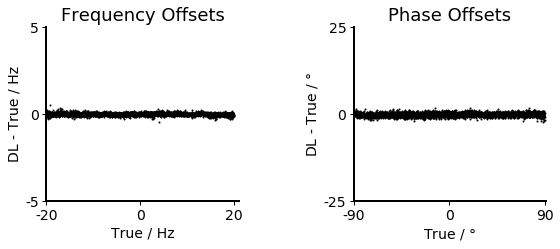

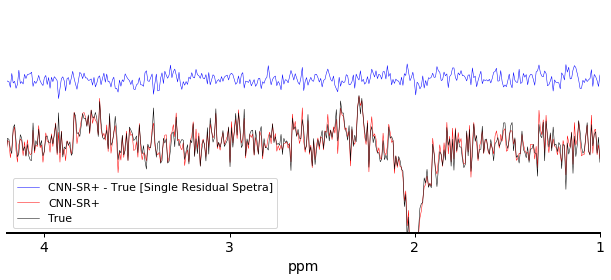

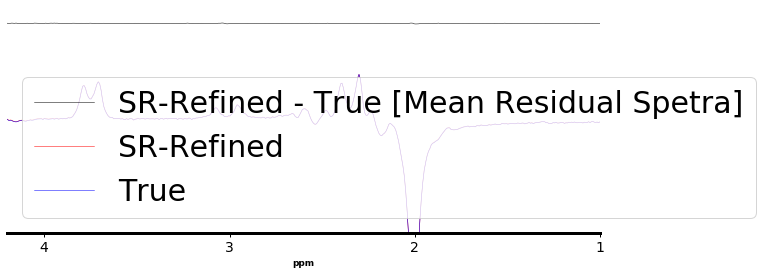

In [25]:
save_model_figurename1='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Figures/DLSR_refined_wNoise1d5dB_wlb_scatterplot.png'
save_model_figurename2='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Figures/DLSR_refined_wNoise1d5dB_wlb_DiffSpectra.png'


# defining residual offsets
F0_residual_offset_OFF=F0_testOFF.numpy()-np.transpose(prediction_F0_OFF)*-1
F0_residual_offset_ON=F0_testON.numpy()-np.transpose(prediction_F0_ON)*-1
Phs_residual_offset_OFF=Phs_testOFF.numpy()-np.transpose(prediction_Phs_OFF)*-1
Phs_residual_offset_ON=Phs_testON.numpy()-np.transpose(prediction_Phs_ON)*-1
F0_residual_offset=np.concatenate((F0_residual_offset_OFF,F0_residual_offset_ON),0)
Phs_residual_offset=np.concatenate((Phs_residual_offset_OFF,Phs_residual_offset_ON),0)

Fids_test=Fids[:,np.r_[18000:20000, 38000:40000]]

# JG: Fids and Spec for the Unaligned data
FidsUnAligned = np.empty((len(Fids_test[:,0]), len(Fids_test[0,:])), dtype = np.complex_)
FidsUnAlignedPhase = np.empty((len(Fids_test[:,0]), len(Fids_test[0,:])), dtype = np.complex_)
spectUnAligned = np.empty((len(Fids_test[:,0]), len(Fids_test[0,:])), dtype = np.complex_)
spectUnAlignedPhase = np.empty((len(Fids_test[:,0]), len(Fids_test[0,:])), dtype = np.complex_)

# JG: Spec for the Original data
# Is this used as ground truth?
spectAligned = np.empty((len(Fids_test[:,0]), len(Fids_test[0,:])), dtype = np.complex_)
spectAlignedPhase = np.empty((len(Fids_test[:,0]), len(Fids_test[0,:])), dtype = np.complex_)

for kk in range(len(Fids_test[0,:])):
    # get the single FID
    Fids_kk = Fids_test[:,kk]
    
    # get the phase and freq offsets
    phasePart = np.exp(-1j * Phs_residual_offset[kk] * cm.pi / 180)
    freqPart = np.exp(-1j * time * F0_residual_offset[kk] * 2 * cm.pi)
    correction = np.multiply(freqPart,phasePart)
    
    # apply the phase and freq offsets on the FID after LB
    FidsUnAligned[:,kk] = np.multiply(Fids_kk, correction) #[2048, 10000]
    FidsUnAlignedPhase[:,kk] = np.multiply(Fids_kk, phasePart) #[2048, 10000]
    
    # get the single spectra of the FID with freq and phase offsets and LB 
    spectUnAligned[:,kk] = fftshift(fft(FidsUnAligned[:,kk]))
    spectUnAlignedPhase[:,kk] = fftshift(fft(FidsUnAlignedPhase[:,kk]))
    
    # get the single spectra of the FID withOUT freq and phase offsets and LB 
    spectAligned[:,kk] = fftshift(fft(Fids_kk))
    spectAlignedPhase[:,kk] = fftshift(fft(Fids_kk))
    
    # get the Normalized single spectra of the FID with freq and phase offsets and LB 
    scale = np.max(np.squeeze(np.abs(spectUnAligned[:,kk])))
    spectUnAligned[:,kk] = spectUnAligned[:,kk]/scale
    scalePh = np.max(np.squeeze(np.abs(spectUnAlignedPhase[:,kk])))
    spectUnAlignedPhase[:,kk] = spectUnAlignedPhase[:,kk]/scalePh
    
    # get the Normalized single spectra of the FID withOUT freq and phase offsets and LB 
    scale = np.max(np.squeeze(np.abs(spectAligned[:,kk])))
    spectAligned[:,kk] = spectAligned[:,kk]/scale
    scalePh = np.max(np.squeeze(np.abs(spectAlignedPhase[:,kk])))
    spectAlignedPhase[:,kk] = spectAlignedPhase[:,kk]/scalePh


# %% Creating the validation figure
fontsize=14

plt.rcParams['axes.linewidth']=2 
plt.rcParams['lines.linewidth']=2 
plt.rcParams['font.size']='30'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

fig = plt.figure(figsize=(8.67, 4.4))

ax = plt.subplot(121)   
#plt.rc('axes', linewidth=1)

ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)     
ax.tick_params(width=1,color='k',length=4)
plt.yticks(np.arange(-5,5.1, step=5),['-5','0','5'], fontsize=fontsize)
plt.xticks(np.arange(-20,21,step=20),['-20','0','20'], fontsize=fontsize)
plt.ylabel('DL - True / Hz', fontname="Arial", fontsize=fontsize)
plt.xlabel('True / Hz', fontname="Arial", fontsize=fontsize)
plt.xlim((-20,21))
plt.ylim((-5, 5))
plt.plot(F0_testOFF.numpy(), np.squeeze(np.array(prediction_F0_OFF)*-1) - np.transpose(F0_testOFF.numpy()), 'ko', markersize=1)
plt.plot(F0_testON.numpy(), np.squeeze(np.array(prediction_F0_ON)*-1) - np.transpose(F0_testON.numpy()), 'ko', markersize=1)
plt.title('Frequency Offsets', fontname="Arial", fontsize=18)

t1 = np.mean(np.squeeze(np.array(prediction_F0_OFF)) - np.transpose(F0_testOFF.numpy()))
t2 = np.mean(np.squeeze(np.array(prediction_F0_ON)) - np.transpose(F0_testON.numpy()))
t3 = (t1 + t2)/2
e1 = np.std(np.squeeze(np.array(prediction_F0_OFF)) - np.transpose(F0_testOFF.numpy()))
e2 = np.std(np.squeeze(np.array(prediction_F0_ON)) - np.transpose(F0_testON.numpy()))
e3 = (e1 + e2)/2
print(r'$ {0:.2f} \pm {1:.2f} \/\degree$'.format(t3,e3))

rcParams['mathtext.default'] = 'regular'
#plt.text(-0.57*20,-0.13,r'$ {0:.2f} \pm {1:.2f} \/Hz$'.format(t3,e3),fontsize=9,fontname="Arial",color='black')
     
ax = plt.subplot(122)
plt.rcParams['axes.linewidth']=2 
plt.rcParams['lines.linewidth']=2 
plt.rcParams['font.size']='30'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)     
ax.tick_params(width=1,color='k',length=4)
plt.yticks(np.arange(-25,25.1,step=25),['-25','0','25'], fontsize=fontsize)
plt.xticks(np.arange(-90,91,step=90),['-90','0','90'], fontsize=fontsize)
plt.ylabel('DL - True /' r' $\degree $', fontname="Arial", fontsize=fontsize)
plt.xlabel('True / ' r'$\degree $', fontname="Arial", fontsize=fontsize)
plt.xlim((-90,91))
plt.ylim((-25, 25))
plt.plot(Phs_testOFF.numpy(), np.squeeze(np.array(prediction_Phs_OFF)*-1) - np.transpose(Phs_testOFF.numpy()), 'ko', markersize=1)
plt.plot(Phs_testON.numpy(), np.squeeze(np.array(prediction_Phs_ON)*-1) - np.transpose(Phs_testON.numpy()), 'ko', markersize=1)
plt.title('Phase Offsets', fontname="Arial", fontsize=18)

t1 = np.mean(np.squeeze(np.array(prediction_Phs_OFF)*-1) - Phs_testOFF.numpy())
t2 = np.mean(np.squeeze(np.array(prediction_Phs_ON)*-1) - Phs_testON.numpy())
t3 = (t1 + t2)/2
e1 = np.std(np.squeeze(np.array(prediction_Phs_OFF)*-1) - Phs_testOFF.numpy())
e2 = np.std(np.squeeze(np.array(prediction_Phs_ON)*-1) - Phs_testON.numpy())
e3 = (e1 + e2)/2
print(r'$ {0:.2f} \pm {1:.2f} \/\degree$'.format(t3,e3))
#plt.text(-0.72*90,-1.3,r'$ {0:.2f} \pm {1:.2f} \/\degree$'.format(t3,e3),fontsize=9,fontname="Arial",color='black')
plt.subplots_adjust(wspace=0.6,left=0.18, right=0.98, top=0.8, bottom=0.25)
plt.savefig(save_model_figurename1,format='png', dpi=300,bbox_inches='tight')  
    
freqRange = 2000/127.7
ppm = np.flip((np.arange(1,2048 + 1)) / 2048 * freqRange + 4.68 - freqRange/2)
xlim = [1, 4.2]

plt.rcParams['axes.linewidth']=2
plt.rcParams['lines.linewidth']=2 
plt.rcParams['font.size']='11'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

fig = plt.figure(figsize=(8.67, 4.5))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)   
ax.tick_params(width=1,color='k',length=4)
plt.xticks(np.arange(1,5,step=1), fontsize=fontsize)
ax.set_yticklabels([])
ax.axes.get_yaxis().set_visible(False)  

lw = 0.5
#spectAligned=np.transpose(spectAligned)
spectAlignedOFF=spectAligned[:,:2000]
spectAlignedON=spectAligned[:,2000:]

spectOFFCorrected=spectUnAligned[:,:2000]
spectONCorrected=spectUnAligned[:,2000:]

############################ Here #################################
k=10
spectONCorrected_real_single = spectONCorrected[:,k].real
spectOFFCorrected_real_single = spectOFFCorrected[:,k].real
spectAlignedON_real_single = spectAlignedON[:,k].real
spectAlignedOFF_real_single = spectAlignedOFF[:,k].real

plt.plot(ppm, spectONCorrected_real_single - spectOFFCorrected_real_single - (spectAlignedON_real_single - spectAlignedOFF_real_single) + 0.014,'b',linewidth=0.5)
plt.plot(ppm, spectONCorrected_real_single - spectOFFCorrected_real_single,'r',linewidth=lw)
plt.plot(ppm, spectAlignedON_real_single - spectAlignedOFF_real_single,'k',linewidth=lw)

plt.xlabel('ppm', fontname="Arial", fontsize=fontsize)
plt.xlim((xlim))
plt.gca().invert_xaxis()
plt.ylim((-0.02,0.03))
plt.legend(['CNN-SR+ - True [Single Residual Spetra]','CNN-SR+','True'],loc="lower left")


plt.subplots_adjust(left=0.03, right=0.98, top=0.95,bottom=0.25)
plt.savefig(save_model_figurename2,format='png', dpi=300,bbox_inches='tight')  

plt.rcParams['axes.linewidth']=3 
plt.rcParams['lines.linewidth']=3 
plt.rcParams['font.size']='30'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

fig = plt.figure(figsize=(8.67, 4.5))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)   
ax.tick_params(width=1,color='k',length=4)
plt.xticks(np.arange(1,5,step=1), fontsize=fontsize)
ax.set_yticklabels([])
ax.axes.get_yaxis().set_visible(False)  

lw = 0.5
plt.plot(ppm, np.mean(spectONCorrected, axis=1).real - np.mean(spectOFFCorrected, axis=1).real - (np.mean(spectAlignedON, axis=1).real - np.mean(spectAlignedOFF, axis=1).real) + 0.017,'k',linewidth=0.5)
plt.plot(ppm, np.mean(spectONCorrected, axis=1).real - np.mean(spectOFFCorrected, axis=1).real,'r',linewidth=lw)
plt.plot(ppm, np.mean(spectAlignedON, axis=1).real - np.mean(spectAlignedOFF, axis=1).real,'b',linewidth=lw)

plt.xlabel('ppm', fontname="Arial", fontsize=9, fontweight='bold')
plt.xlim((xlim))
plt.gca().invert_xaxis()
plt.ylim((-0.02,0.02))
plt.legend(['SR-Refined - True [Mean Residual Spetra]','SR-Refined','True'],loc="lower left")
plt.subplots_adjust(left=0.03, right=0.98, top=0.95,bottom=0.25)
#plt.savefig(save_model_figurename2,format='png', dpi=300)  

#### Diff AUC Percentage

In [32]:
import scipy
from scipy import integrate

freqRange = 2000/127.7
ppm = np.flip((np.arange(1,2048 + 1)) / 2048 * freqRange + 4.68 - freqRange/2)

GABA_Int = np.where((ppm <= 5) & (ppm >= 1))
Glx_Int= np.where((ppm >= 3.55) & (ppm <= 3.95))

################ GABA ##############################
spectDiffCorrected = spectONCorrected - spectOFFCorrected 
spectAlignedDiff = spectAlignedON - spectAlignedOFF

spectDiffCorrected_GABA=spectDiffCorrected[GABA_Int[0][0]:GABA_Int[0][-1]]
spectAlignedDiff_GABA=spectAlignedDiff[GABA_Int[0][0]:GABA_Int[0][-1]]

GABA_AUC=np.zeros((spectAlignedDiff_GABA.shape[1]))

for sample in range(len(GABA_AUC)):
    AUC_spectDiffCorrected_GABA=scipy.integrate.trapz(spectDiffCorrected_GABA[:,sample],ppm[GABA_Int[0][0]:GABA_Int[0][-1]])
    AUC_spectALignedDiff_GABA=scipy.integrate.trapz(spectAlignedDiff_GABA[:,sample],ppm[GABA_Int[0][0]:GABA_Int[0][-1]])
    GABA_AUC[sample]= abs(AUC_spectDiffCorrected_GABA.real-AUC_spectALignedDiff_GABA.real)/abs(AUC_spectALignedDiff_GABA.real)

GABA_AUC_mean=np.mean(GABA_AUC)
GABA_AUC_std=np.std(GABA_AUC)

print("Diff Spectra AUC GABA: ", GABA_AUC_mean, "+-", GABA_AUC_std)

################ Glx ##############################
spectDiffCorrected_Glx=spectDiffCorrected[Glx_Int[0][0]:Glx_Int[0][-1]]
spectAlignedDiff_Glx=spectAlignedDiff[Glx_Int[0][0]:Glx_Int[0][-1]]

Glx_AUC=np.zeros((spectAlignedDiff_Glx.shape[1]))

for sample in range(len(Glx_AUC)):
    AUC_spectDiffCorrected_Glx=scipy.integrate.trapz(spectDiffCorrected_Glx[:,sample],ppm[Glx_Int[0][0]:Glx_Int[0][-1]])
    AUC_spectALignedDiff_Glx=scipy.integrate.trapz(spectAlignedDiff_Glx[:,sample],ppm[Glx_Int[0][0]:Glx_Int[0][-1]])
    Glx_AUC[sample]= abs(AUC_spectDiffCorrected_Glx.real-AUC_spectALignedDiff_Glx.real)/abs(AUC_spectALignedDiff_Glx.real)

Glx_AUC_mean=np.mean(Glx_AUC)
Glx_AUC_std=np.std(Glx_AUC)

print("Diff Spectra AUC Glx: ", Glx_AUC_mean, "+-", Glx_AUC_std)

Diff Spectra AUC GABA:  0.36367175678735086 +- 0.5244948197845754
Diff Spectra AUC Glx:  0.1327022099816171 +- 0.11108326240891828


In [33]:
# Diff Spectra
freqRange = 2000/127.7
ppm = np.flip((np.arange(1,2048 + 1)) / 2048 * freqRange + 4.68 - freqRange/2)

GABA_Int = np.where((ppm <= 3.20) & (ppm >= 2.80))
Glx_Int= np.where((ppm >= 3.55) & (ppm <= 3.95))

################ GABA ##############################
spectDiffCorrected = spectONCorrected - spectOFFCorrected 
spectAlignedDiff = spectAlignedON - spectAlignedOFF

spectDiffCorrected_GABA=spectDiffCorrected[GABA_Int[0][0]:GABA_Int[0][-1]]
spectAlignedDiff_GABA=spectAlignedDiff[GABA_Int[0][0]:GABA_Int[0][-1]]

spectDiff_residue_GABA = spectDiffCorrected_GABA - spectAlignedDiff_GABA
spectDiff_residue_MAE_mean_GABA = np.mean(np.mean(np.absolute(spectDiff_residue_GABA),axis=0))
spectDiff_residue_MAE_STD_GABA = np.std(np.mean(np.absolute(spectDiff_residue_GABA),axis=0))
print("GABA Mean Absolute Error: ", spectDiff_residue_MAE_mean_GABA, " +- ", spectDiff_residue_MAE_STD_GABA)

################ Glx ##############################
spectDiffCorrected_Glx=spectDiffCorrected[Glx_Int[0][0]:Glx_Int[0][-1]]
spectAlignedDiff_Glx=spectAlignedDiff[Glx_Int[0][0]:Glx_Int[0][-1]]

spectDiff_residue_Glx = spectDiffCorrected_Glx - spectAlignedDiff_Glx
spectDiff_residue_MAE_mean_Glx = np.mean(np.mean(np.absolute(spectDiff_residue_Glx),axis=0))
spectDiff_residue_MAE_STD_Glx = np.std(np.mean(np.absolute(spectDiff_residue_Glx),axis=0))
print("Glx Mean Absolute Error: ", spectDiff_residue_MAE_mean_Glx, " +- ", spectDiff_residue_MAE_STD_Glx)

GABA Mean Absolute Error:  0.0008372089714050314  +-  0.00045538669057014437
Glx Mean Absolute Error:  0.0008504522857880234  +-  0.0004426791760333327


In [34]:
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_Refined_1d5dB_wLB_spectra_DIFF_Residual_GABA_MAE.npy', np.mean(np.absolute(spectDiff_residue_GABA),axis=0))
np.save('/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/Prediction_data/MAE_data/SR_Refined_1d5dB_wLB_spectra_DIFF_Residual_Glx_MAE.npy', np.mean(np.absolute(spectDiff_residue_Glx),axis=0))